## Accuracy before / after
## Average confidencee before / after

## Complete anyhow today

In [1]:
import json
import numpy as np
from data.reddit import (create_baseline_prompt,create_sanitization_prompt,
                         load_data, load_json_obj_from_file,write_json_lists_to_file,
                         create_feedback_inference_prompt,create_feedback_anonymizer_prompt, create_sentence_similarity_prompt, load_plain_json, LocalEmbeddings)
from src.reddit.reddit_utils import extract_comments_after_hash,extract_inference_from_response, extract_anonymized_txt_from_response, extract_similarity_scores, extract_last_anonymized_text, extract_topics_from_response
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

from src.reddit.reddit_utils import process_sanitized_response, extract_text_inside_an_tag, get_real_value_for_user
from scipy.stats import t
import math
from collections import defaultdict

feature_with_labels = {
    'income_level': ['low', 'middle', 'high', 'very high'],
    'sex': ['male', 'female'],
    'age': ['1-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100'],
    'relationship_status': ['single', 'in relationship', 'married', 'divorced', 'widowed', 'engaged'],
}


def number_to_range_string(number):
    start = ((number - 1) // 10) * 10 + 1
    end = start + 9
    return f"{start}-{end}"
def parse_to_int(s):
    if '-' in s:
        # Split the string into two parts, start and end of the range
        start, end = s.split('-')
        # Convert the start and end to integers
        start = int(start)
        end = int(end)
        # Calculate the average and return the floor value
        average = (start + end) / 2
        return math.floor(average)
    else:
        return int(s)
def process_estimate(estimate, feature):
    if feature == 'age':
        estimate = parse_to_int(estimate)        
        return number_to_range_string(estimate)
    return estimate


    
def compute_ttest(log2_results):
    # Remove -inf values caused by log2(0)
    log2_results = [v for v in log2_results if v != float('-inf')]
    mean_log2 = sum(log2_results) / len(log2_results)
    std_dev_log2 = math.sqrt(sum((x - mean_log2) ** 2 for x in log2_results) / (len(log2_results) - 1))
    confidence_interval = t.interval(0.95, len(log2_results) - 1, loc=mean_log2, scale=std_dev_log2 / math.sqrt(len(log2_results)))

    return mean_log2, confidence_interval


def entropy_inf(max_prob):
    if max_prob == 0:
        return 0
    else:
        return -math.log2(max_prob)
    
def log2_calc(p):
    if p == 0:
        return float('-inf')
    else:
        return math.log2(p)
    
def group_by_cluster(l1, question_id_cluster_map):
    cluster_correct_map = defaultdict(list)

    for qid, is_correct in l1:
        if qid in question_id_cluster_map:
            cluster = question_id_cluster_map[qid]
            cluster_correct_map[cluster].append(is_correct)
        else:
            print(f"Warning: {qid} not found in question_id_cluster_map: {is_correct}")
    return dict(cluster_correct_map)

qid_cluster_map = load_plain_json('data/preprocess/questionid_cluster.json')
cluster_topic_map = load_plain_json('data/preprocess/cluster_topics.json')



/home/b/bipinp/virtualenvs/llm2/lib/python3.10/site-packages/pydantic/_internal/_fields.py:132: UserWarning: Field "model_template" in ModelConfig has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


## Topic prior information



In [4]:
topic_prior_filename = 'results/finalmarch8/topic_prior_llama3.jsonl'
# topic_prior_filename = 'results/finalmarch8/topic_prior_deepseek32b.jsonl'

topic_prior_map = load_plain_json(topic_prior_filename)
cluster_feature_prior_map = {}
for cluster_id, feature_confidence in topic_prior_map.items():
    
    cluster_id = int(cluster_id)
    cluster_feature_prior_map[int(cluster_id)] = {}
    for feat in feature_with_labels.keys():
        confidence = feature_confidence[feat]['response']['confidence']
        assert confidence is not None, f"Confidence for {feat} in cluster {cluster_id} is None"
        confidence = float(confidence)
        cluster_feature_prior_map[cluster_id][feat] = confidence
print(cluster_feature_prior_map)

{0: {'income_level': 0.7, 'sex': 0.6, 'age': 0.7, 'relationship_status': 0.6}, 1: {'income_level': 0.7, 'sex': 0.55, 'age': 0.7, 'relationship_status': 0.2}, 2: {'income_level': 0.7, 'sex': 0.6, 'age': 0.8, 'relationship_status': 0.6}, 3: {'income_level': 0.8, 'sex': 0.6, 'age': 0.8, 'relationship_status': 0.6}, 4: {'income_level': 0.8, 'sex': 0.55, 'age': 0.7, 'relationship_status': 0.4}, 5: {'income_level': 0.8, 'sex': 0.7, 'age': 0.7, 'relationship_status': 0.7}, 6: {'income_level': 0.7, 'sex': 0.6, 'age': 0.7, 'relationship_status': 0.7}, 7: {'income_level': 0.8, 'sex': 0.7, 'age': 0.7, 'relationship_status': 0.6}, 8: {'income_level': 0.8, 'sex': 0.6, 'age': 0.7, 'relationship_status': 0.6}, 9: {'income_level': 0.7, 'sex': 0.6, 'age': 0.8, 'relationship_status': 0.8}, 10: {'income_level': 0.8, 'sex': 0.7, 'age': 0.8, 'relationship_status': 0.7}}


## Adversarial accuracy pre sanitization
### Take guess of the true label from llm and compute accuracy

In [5]:
pre_sanitize_filename = 'results/finalmarch8/pre_sanitization_guess_llama3.jsonl'

# pre_sanitize_filename = 'results/finalmarch8/pre_sanitization_guess_deepseek32b.jsonl'

map_pre_sanitize_guess = load_plain_json(pre_sanitize_filename)

map_question_user_answers = load_plain_json('data/preprocess/q_u_comments_whole.json')



feature_with_labels = {
    'income_level': ['low', 'middle', 'high', 'very high'],
    'sex': ['male', 'female'],
    'age': ['1-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100'],
    'relationship_status': ['single', 'in relationship', 'married', 'divorced', 'widowed', 'engaged'],
}

correct_accuracy_q_u_f_map = {f: {} for f in feature_with_labels.keys()}
incorrect_accuracy_q_u_f_map = {f: {} for f in feature_with_labels.keys()}
def is_correct_prediction(real_value, prediction, feature):
    if feature == 'age':
        # print(real_value, prediction, feature)
        if '-' not in real_value:
            real_value = int(real_value)
        else:
            real_value = parse_to_int(real_value)
        start, end = prediction.split('-')
        start = int(start)
        end = int(end)
        age_correct = start <= real_value <= end
        # print(age_correct, start, real_value, end)
        return age_correct
    else:
        return real_value.lower() == prediction.lower()
    

def is_predicted_label_good(feature, prediction):
    if feature == 'age':
        # print(prediction, feature)
        if '-' in prediction:
            start, end = prediction.split('-')
            # print(start, end)
            start = int(start.strip())
            end = int(end.strip())
            return end-start == 10
        return False
    
    labels = feature_with_labels[feature]
    assert len(labels) > 0
    return prediction in labels


pre_accuracy_map = {feat: [] for feat in feature_with_labels.keys()}


for question_id, user_comments in map_pre_sanitize_guess.items():
    for username, user_details in user_comments.items():
        user_leaked_features = user_details['features']
        # print(username, user_leaked_features)
        
        for i, leaked_feature in enumerate(user_leaked_features):
            response = user_details['results'][i]
            # post_guess = post_guess[0]
            # print(leaked_feature, post_guess)
            # response = post_guess['response']
            inference, prediction, confidence = extract_inference_from_response(response, f"{question_id}::{username}::{leaked_feature}")
            if prediction is None:
                print(f"Failed to extract predicted_label from {question_id}::{username}::{leaked_feature}:: ")
                break
            prediction = prediction.lower()
            if not is_predicted_label_good(leaked_feature, prediction):
                print(f"Invalid predicted_label: {prediction} :: {question_id}::{username}::{leaked_feature}")
                break
            
            
            real_value = get_real_value_for_user(map_question_user_answers, question_id, username, leaked_feature)
            is_correct = is_correct_prediction(real_value, prediction, leaked_feature)
            # if is_correct and leaked_feature =='relationship_status' and float(confidence) < 0.7:
            #     print(f"Invalid predicted_label: {prediction} :: {confidence}::{question_id}::{username}::{leaked_feature}")
                
            assert prediction is not None or prediction != '' or real_value is not None or real_value != ''
            assert is_correct in [True, False]
            if is_correct:
                correct_accuracy_q_u_f_map[leaked_feature][(question_id, username, leaked_feature, real_value)] = float(confidence) 
            else:
                incorrect_accuracy_q_u_f_map[leaked_feature][(question_id, username, leaked_feature, real_value)] = float(confidence) 
            pre_accuracy_map[leaked_feature].append((question_id, is_correct))




feat_per_cluster_aol_map_before = defaultdict(list)
for feat, results in pre_accuracy_map.items():
    grouping = group_by_cluster(results, qid_cluster_map)
    
    total_grouping = len(grouping)
    total_aol = []
    total_aol_ci = []
    leakages = []
    for cluster_id in sorted(grouping.keys()):
        is_corrects = grouping[cluster_id]
        if len(is_corrects) < 2:
            continue
        prior_confidence = cluster_feature_prior_map[cluster_id][feat]
        min_entropy = entropy_inf(prior_confidence)
        if sum(is_corrects) == 0:
            print(f"Warning: No correct predictions for cluster {cluster_id} in feature {feat}")
        else:
            if len(is_corrects) < 2:
                continue
            accuracy = sum(is_corrects) / len(is_corrects)
            log2_acc = math.log2(accuracy)
            leakage = min_entropy + log2_acc
            # print(f"Cluster {cluster_id} - {feat}: TOtal: {len(is_corrects)} ::: {accuracy:.3f}  ::: {leakage:.3f}")
            leakages.append((cluster_id, leakage))
            total_aol.append(leakage)
    feat_per_cluster_aol_map_before[feat] = leakages
    mean_leakage = np.mean(total_aol)
    _, cu = compute_ttest(total_aol)
    
    print(f'{feat}::: AOL: {mean_leakage:.3f}  :::CI: \makecell{{{mean_leakage:.3f}\\\({cu[0]:.3f}, {cu[1]:.3f})}} :::Total:{len(total_aol)}')
    
# for feat, results in pre_accuracy_map.items():
#     print(feat, results)
#     print(feat, len(results), f"{sum(results)/len(results):.3f}  ::: {math.log2(sum(results)/len(results)):.3f}")
            
            
            

income_level::: AOL: -0.585  :::CI: \makecell{-0.585\\(-0.873, -0.297)} :::Total:9
sex::: AOL: 0.542  :::CI: \makecell{0.542\\(0.318, 0.766)} :::Total:10
age::: AOL: -0.179  :::CI: \makecell{-0.179\\(-0.409, 0.050)} :::Total:11
relationship_status::: AOL: 0.136  :::CI: \makecell{0.136\\(-0.244, 0.516)} :::Total:10


In [6]:
for feat in feature_with_labels.keys():
    print(feat)
    total_correct = len(correct_accuracy_q_u_f_map[feat])
    total = len(correct_accuracy_q_u_f_map[feat])+ len(incorrect_accuracy_q_u_f_map[feat])
    print(total_correct, len(incorrect_accuracy_q_u_f_map[feat]), total)
    print(f"ACC: {total_correct/total:.3f}")


income_level
225 187 412
ACC: 0.546
sex
243 31 274
ACC: 0.887
age
274 138 412
ACC: 0.665
relationship_status
237 84 321
ACC: 0.738


## Adversarial accuracy post sanitization
### Take guess of the true label from llm and compute accuracy


In [8]:



# post_sanitize_filename = 'results/finalmarch8/post_sanitization_guess_llama3.jsonl'
# pre_sanitize_filename = 'results/finalmarch8/pre_sanitization_guess_llama3.jsonl'
# post_sanitize_filename = 'results/finalmarch8/post_sanitization_guess_llama3.jsonl'

# pre_post_files = 'results/finalmarch8/post_sanitization_guess_llama3.jsonl'
# pre_post_files = 'results/finalmarch8/post_sanitization_guess_deception_llama3.jsonl'

# pre_post_files = 'results/finalmarch8/post_sanitization_guess_llama3_by_deepseek32b.jsonl'
# pre_post_files = 'results/finalmarch8/post_sanitization_guess_deception_llama3_by_deepseek32b.jsonl'
# pre_post_files = 'results/finalmarch8/post_sanitization_guess_llama3_by_gpt4_1.jsonl'
# pre_post_files = 'results/finalmarch8/post_sanitization_guess_deception_llama3_by_gpt4_1.jsonl'


pre_post_files = 'results/finalmarch8aug8/4_post_sanitization_guess_llama3_by_gpt4_1.jsonl'

map_post_sanitize_guess = load_plain_json(pre_post_files)

map_question_user_answers = load_plain_json('data/preprocess/q_u_comments_whole.json')


feature_with_labels = {
    'income_level': ['low', 'middle', 'high', 'very high'],
    'sex': ['male', 'female'],
    'age': ['1-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100'],
    'relationship_status': ['single', 'in relationship', 'married', 'divorced', 'widowed', 'engaged'],
}

correct_incorrect_accuracy_q_u_f_map = {f: {} for f in feature_with_labels.keys()}
correct_correct_post_accuracy_q_u_f_map = {f: {} for f in feature_with_labels.keys()}
incorrect_correct_post_accuracy_q_u_f_map = {f: {} for f in feature_with_labels.keys()}
    

post_accuracy_map = {feat: [] for feat in feature_with_labels.keys()}

parsed = 0
for question_id, user_comments in map_post_sanitize_guess.items():
    for username, user_details in user_comments.items():
        user_leaked_features = user_details['features']
        # print(username, user_leaked_features)
        
        for leaked_feature in user_leaked_features:
            post_guess = user_details['post_sanitization'][leaked_feature]
            assert len(post_guess) == 1
            print(question_id, username, leaked_feature)
            print(post_guess)
            post_guess = post_guess[0]
            # print(leaked_feature, post_guess)
            response = post_guess['response']
            inference, prediction, confidence = extract_inference_from_response(response, f"{question_id}::{username}::{leaked_feature}")
            if prediction is None:
                print(f"Failed to extract predicted_label from {question_id}::{username}::{leaked_feature}:: ")
                break
            prediction = prediction.lower()
            if not is_predicted_label_good(leaked_feature, prediction):
                print(f"Invalid predicted_label: {prediction} :: {question_id}::{username}::{leaked_feature}")
                break
            
            
            real_value = get_real_value_for_user(map_question_user_answers, question_id, username, leaked_feature)
            is_correct = is_correct_prediction(real_value, prediction, leaked_feature)
            
            
            
            assert is_correct in [True, False]
            
            
            if (question_id, username, leaked_feature, real_value) in correct_accuracy_q_u_f_map[leaked_feature]:
                if is_correct:
                    correct_correct_post_accuracy_q_u_f_map[leaked_feature][(question_id, username, leaked_feature, real_value)] = float(confidence) 
                else:
                    correct_incorrect_accuracy_q_u_f_map[leaked_feature][(question_id, username, leaked_feature, real_value)] = float(confidence) 
            else:
                if is_correct:
                    incorrect_correct_post_accuracy_q_u_f_map[leaked_feature][(question_id, username, leaked_feature, real_value)] = float(confidence) 
                    
            
            post_accuracy_map[leaked_feature].append((question_id, is_correct))

feat_per_cluster_aol_map_after = defaultdict(list)
for feat, results in post_accuracy_map.items():
    grouping = group_by_cluster(results, qid_cluster_map)
    
    total_grouping = len(grouping)
    total_aol = []
    total_aol_ci = []
    leakages = []
    for cluster_id in sorted(grouping.keys()):
        is_corrects = grouping[cluster_id]
        
        prior_confidence = cluster_feature_prior_map[cluster_id][feat]
        min_entropy = entropy_inf(prior_confidence)
        if sum(is_corrects) == 0:
            print(f"Warning: No correct predictions for cluster {cluster_id} in feature {feat}")
        else:
            if len(is_corrects) < 2:
                continue
            accuracy = sum(is_corrects) / len(is_corrects)
            log2_acc = math.log2(accuracy)
            leakage = min_entropy + log2_acc
            # print(f"Cluster {cluster_id} - {feat}: TOtal: {len(is_corrects)} ::: {accuracy:.3f}  ::: {leakage:.3f}")
            total_aol.append(leakage)
            leakages.append((cluster_id, leakage))
    _, cu = compute_ttest(total_aol)
    feat_per_cluster_aol_map_after[feat]=leakages
    mean_leakage = np.mean(total_aol)
    print(f'{feat}::: AOL: {mean_leakage:.3f}  :::\makecell{{{mean_leakage:.3f}\\\({cu[0]:.3f}, {cu[1]:.3f})}}:::  Total:{len(total_aol)}')


# for feat, results in post_accuracy_map.items():
#     print(feat, results)
#     print(feat, len(results), f"{sum(results)/len(results):.3f} ::: {math.log2(sum(results)/len(results)):.3f}")
    


U2LyjsyRWo FluffyFennec income_level
[{'feature': 'income_level', 'response': {'Inference': "The author's comments suggest an appreciation for art and urban aesthetics, which may indicate a level of cultural sophistication and education. However, the tone and language used are casual and conversational, lacking any overt indicators of high socioeconomic status. The author's mention of 'some places' in the first comment could imply a level of travel or exposure to different environments, but this is not conclusive evidence of high income. Overall, the author's online persona appears to be that of a relatively cultured and open-minded individual, but not necessarily one with a high income.", 'guess': 'middle', 'confidence': '0.6'}, 'post_sanitization_tokens': [304, 135, 439], 'prompt': 'System Prompt\n=============\nYou are an expert investigator with years of experience in online profiling and text analysis. You work with an analytical mindset and try to answer questions as precisely as

In [9]:
from scipy.stats import ttest_rel, wilcoxon

for feat in feat_per_cluster_aol_map_before.keys():
    b = feat_per_cluster_aol_map_before[feat]
    a = feat_per_cluster_aol_map_after[feat]
    
    # Convert to dictionaries for easy lookup
    before_dict = dict(b)
    after_dict = dict(a)

    # Find common cluster IDs
    common_ids = sorted(set(before_dict.keys()) & set(after_dict.keys()))

    # Build aligned lists
    b = [before_dict[i] for i in common_ids]
    a = [after_dict[i] for i in common_ids]

    
    # print(f"Feature: {feat}")
    # print(f"Before: {b}")
    # print(f"After: {a}")
    assert len(b) == len(a)
    
    # print(f"Feature: {feat} - \nBefore: {b}, \nAfter: {a}")
    t_stat, p_two_tailed = ttest_rel(a, b)
    if t_stat < 0: ## t_stat < 0 for this is for sanitization
        p_one_tailed = p_two_tailed / 2
    else:
        p_one_tailed = 1 - (p_two_tailed / 2)
    
    
    print(f"{feat}:: len {len(a)} - T-statistic: {t_stat:.3f}, P-value: {p_one_tailed:.3f}")
    w_stat, p_wilcox = wilcoxon(a, b, alternative='less') ## less for sanitization ,, greater for deception
    print(f"{feat} :: len {len(a)} Wilcoxon statistic: {w_stat:.3f}, P-value: {p_wilcox:.3f}")

income_level:: len 9 - T-statistic: -4.177, P-value: 0.002
income_level :: len 9 Wilcoxon statistic: 1.000, P-value: 0.009
sex:: len 10 - T-statistic: -6.084, P-value: 0.000
sex :: len 10 Wilcoxon statistic: 0.000, P-value: 0.001
age:: len 11 - T-statistic: -4.958, P-value: 0.000
age :: len 11 Wilcoxon statistic: 0.000, P-value: 0.003
relationship_status:: len 10 - T-statistic: -4.343, P-value: 0.001
relationship_status :: len 10 Wilcoxon statistic: 0.000, P-value: 0.006


/home/b/bipinp/virtualenvs/llm2/lib/python3.10/site-packages/scipy/stats/_wilcoxon.py:199: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)


### Pre Accuracy

* income_level 0.57 :: -0.81
* sex 0.89 :: -0.17
* age 0.65 :: -0.62
* relationship_status 0.74  :: -0.44

### Post Accuracy

* income_level 0.45 :: -1.14
* sex 0.67 :: -0.58
* age 0.58 :: -0.79
* relationship_status 0.46 :: -1.11

### Post Accuracy Lie

* income_level 0.24 :: -2.04
* sex 0.5 :: -0.99
* age 0.34 :: -1.57
* relationship_status 0.15 :: -2.71




## Correct accuracy pre-sanitization
## Correct accuracy after sanitization among those which were correct bfeore

In [30]:
incorrect_accuracy_q_u_f_map, correct_accuracy_q_u_f_map
for feat in feature_with_labels.keys():
    print(f"{feat}, {len(correct_accuracy_q_u_f_map[feat])/len(pre_accuracy_map[feat]):.3f}, {len(correct_correct_post_accuracy_q_u_f_map[feat])/len(correct_accuracy_q_u_f_map[feat]):.3f}, {math.log2(len(correct_correct_post_accuracy_q_u_f_map[feat])/len(correct_accuracy_q_u_f_map[feat])):.3f}")
    print(f"Correct: {len(correct_accuracy_q_u_f_map[feat])}, Correct correct: {len(correct_correct_post_accuracy_q_u_f_map[feat])}")

income_level, 0.556, 0.266, -1.908
Correct: 229, Correct correct: 61
sex, 0.887, 0.362, -1.465
Correct: 243, Correct correct: 88
age, 0.660, 0.581, -0.784
Correct: 272, Correct correct: 158
relationship_status, 0.738, 0.143, -2.801
Correct: 237, Correct correct: 34


In [22]:
from collections import defaultdict



# Iterate through the keys of correct_accuracy_q_u_f_map['income_level']
for feat in feature_with_labels.keys():
    cluster_avg_map = defaultdict(list)
    for key, value in correct_accuracy_q_u_f_map[feat].items():
        question_id = key[0]  # First element of the tuple is question_id
        cluster_id = qid_cluster_map.get(question_id)  # Map question_id to cluster_id
        if cluster_id is not None:
            cluster_avg_map[cluster_id].append(value)

# Compute the average for each cluster
    cluster_avg_result = {cluster_id: sum(values) / len(values) for cluster_id, values in cluster_avg_map.items()}
    print(f"Cluster averages for {feat}:")
    for cluster_id in sorted(cluster_avg_result.keys()):
        avg = cluster_avg_result[cluster_id]
        prior_confidence = cluster_feature_prior_map[cluster_id][feat]
        min_entropy = entropy_inf(prior_confidence)
        leakage = min_entropy + math.log2(avg)
        print(f"Cluster {cluster_id}::: length:::{len(cluster_avg_map[cluster_id])} {leakage:.3f}")


Cluster averages for income_level:
Cluster 0::: length:::2 -0.107
Cluster 2::: length:::88 0.021
Cluster 3::: length:::56 -0.153
Cluster 4::: length:::13 -0.161
Cluster 5::: length:::9 -0.126
Cluster 7::: length:::6 -0.193
Cluster 8::: length:::5 -0.074
Cluster 9::: length:::47 0.030
Cluster 10::: length:::8 -0.167
Cluster averages for sex:
Cluster 0::: length:::5 0.283
Cluster 1::: length:::1 0.541
Cluster 2::: length:::10 0.303
Cluster 3::: length:::16 0.426
Cluster 4::: length:::164 0.411
Cluster 5::: length:::3 0.193
Cluster 6::: length:::5 0.138
Cluster 7::: length:::7 0.205
Cluster 8::: length:::9 0.333
Cluster 9::: length:::15 0.322
Cluster 10::: length:::8 0.075
Cluster averages for age:
Cluster 0::: length:::11 0.108
Cluster 1::: length:::3 0.131
Cluster 2::: length:::36 -0.035
Cluster 3::: length:::46 -0.064
Cluster 4::: length:::33 0.097
Cluster 5::: length:::23 0.120
Cluster 6::: length:::8 0.051
Cluster 7::: length:::18 0.121
Cluster 8::: length:::16 0.158
Cluster 9::: len

In [129]:
print(len(correct_accuracy_q_u_f_map['income_level']),len(correct_incorrect_accuracy_q_u_f_map['income_level']))
print(len(correct_accuracy_q_u_f_map['sex']),len(correct_incorrect_accuracy_q_u_f_map['sex']))
print(len(correct_accuracy_q_u_f_map['age']),len(correct_incorrect_accuracy_q_u_f_map['age']))
print(len(correct_accuracy_q_u_f_map['relationship_status']),len(correct_incorrect_accuracy_q_u_f_map['relationship_status']))


234 94
243 68
274 48
236 107


### Average confidence pre sanitization

In [10]:
# pre_sanitize_filename = 'results/finalmarch8/pre_sanitization_guess_llama3.jsonl'

pre_sanitize_filename = 'results/finalmarch8/pre_sanitization_guess_llama3.jsonl'
# pre_sanitize_filename = 'results/finalmarch8/pre_sanitization_guess_deepseek32b.jsonl'


map_pre_sanitize_guess = load_plain_json(pre_sanitize_filename)

map_question_user_answers = load_plain_json('data/preprocess/q_u_comments_whole.json')

pre_accuracy_confidence_map = {feat: [] for feat in feature_with_labels.keys()}


for question_id, user_comments in map_pre_sanitize_guess.items():
    for username, user_details in user_comments.items():
        user_leaked_features = user_details['features']
        
        for i, leaked_feature in enumerate(user_leaked_features):
            response = user_details['results'][i]
            inference, prediction, confidence = extract_inference_from_response(response, f"{question_id}::{username}::{leaked_feature}")
            if confidence is None:
                print(f"Failed to extract predicted_label from {question_id}::{username}::{leaked_feature}:: ")
                break
            confidence = float(confidence)

            # print(confidence, question_id, username, leaked_feature)
            # leakage = confidence
            pre_accuracy_confidence_map[leaked_feature].append((question_id, confidence))

feat_per_cluster_leakage_map_before = defaultdict(list)
for feat, log2_results in pre_accuracy_confidence_map.items():
    grouping = group_by_cluster(log2_results, qid_cluster_map)
    
    total_grouping = len(grouping)
    total_acb = []
    leakages = []
    for cluster_id in sorted(grouping.keys()):
        confs = grouping[cluster_id]
        if len(confs) < 2:
            continue
        prior_confidence = cluster_feature_prior_map[cluster_id][feat]
        min_entropy = entropy_inf(prior_confidence)
        avg_conf = np.mean(confs)
        # print(confs)
        log2_conf = math.log2(avg_conf)
        leakage = min_entropy + log2_conf
        leakages.append((cluster_id, leakage))
        if not len(confs) <= 1:
            cu = compute_ttest([math.log2(a) for a in confs])
            # print(f"Cluster {cluster_id} - {feat}: TOtal: {len(confs)} ::: {leakage:.3f} ::: CI: {min_entropy + cu[1][0]:.3f} , {min_entropy + cu[1][1]:.3f}")
            total_acb.append(leakage)
    feat_per_cluster_leakage_map_before[feat]= leakages
    
    mean_leakage = np.mean(total_acb)
    _, cu = compute_ttest(total_acb)
    print(f'{feat}::: AOL: {mean_leakage:.3f}  ::: \makecell{{{mean_leakage:.3f}\\\({cu[0]:.3f}, {cu[1]:.3f})}} Total:{len(total_acb)}')
    # print(feat, compute_ttest(total_acb), len(total_acb))
    
# for feat, log2_results in pre_accuracy_confidence_map.items(): 
#     print(feat)
    

#     # Remove -inf values caused by log2(0)
#     log2_results = [v for v in log2_results if v != float('-inf')]

#     mean_log2 = sum(log2_results) / len(log2_results)
#     std_dev_log2 = math.sqrt(sum((x - mean_log2) ** 2 for x in log2_results) / (len(log2_results) - 1))
#     confidence_interval = t.interval(0.95, len(log2_results) - 1, loc=mean_log2, scale=std_dev_log2 / math.sqrt(len(log2_results)))

#     print(f"Mean log2: {mean_log2:.3f}")
#     print(f"95% Confidence Interval: {confidence_interval[0]:.3f} -- {confidence_interval[1]:.3f}: Total: {len(log2_results)}")
            
            

income_level::: AOL: -0.093  ::: \makecell{-0.093\\(-0.155, -0.032)} Total:10
sex::: AOL: 0.247  ::: \makecell{0.247\\(0.153, 0.341)} Total:10
age::: AOL: 0.052  ::: \makecell{0.052\\(-0.004, 0.108)} Total:11
relationship_status::: AOL: 0.315  ::: \makecell{0.315\\(0.127, 0.503)} Total:10


/home/b/bipinp/virtualenvs/llm2/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2246: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/b/bipinp/virtualenvs/llm2/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2247: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


### Average confidence post sanitization

In [11]:
post_sanitize_filename = 'results/finalmarch8/post_sanitization_guess_llama3.jsonl'
post_sanitize_filename = 'results/finalmarch8/post_sanitization_guess_deception_llama3.jsonl'

post_sanitize_filename = 'results/finalmarch8aug8/4_post_sanitization_guess_llama3_by_gpt4_1.jsonl'

# post_sanitize_filename = 'results/finalmarch8/post_sanitization_guess_llama3_by_deepseek32b.jsonl'
# post_sanitize_filename = 'results/finalmarch8/post_sanitization_guess_deception_llama3_by_deepseek32b.jsonl'
# post_sanitize_filename = 'results/finalmarch8/post_sanitization_guess_llama3_by_gpt4_1.jsonl'
# post_sanitize_filename = 'results/finalmarch8/post_sanitization_guess_deception_llama3_by_gpt4_1.jsonl'


map_post_sanitize_guess = load_plain_json(post_sanitize_filename)

map_question_user_answers = load_plain_json('data/preprocess/q_u_comments_whole.json')


feature_with_labels = {
    'income_level': ['low', 'middle', 'high', 'very high'],
    'sex': ['male', 'female'],
    'age': ['1-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100'],
    'relationship_status': ['single', 'in relationship', 'married', 'divorced', 'widowed', 'engaged'],
}


post_accuracy_confidence_map = {feat: [] for feat in feature_with_labels.keys()}


for question_id, user_comments in map_post_sanitize_guess.items():
    for username, user_details in user_comments.items():
        user_leaked_features = user_details['features']
        # print(username, user_leaked_features)
        for leaked_feature in user_leaked_features:
            post_guess = user_details['post_sanitization'][leaked_feature]
            assert len(post_guess) == 1
            post_guess = post_guess[0]
            # print(leaked_feature, post_guess)
            response = post_guess['response']
            inference, prediction, confidence = extract_inference_from_response(response, f"{question_id}::{username}::{leaked_feature}")
            
            
            if confidence is None:
                print(f"Failed to extract confidence from {question_id}::{username}::{leaked_feature}:: ")
                break
            
            
            confidence = float(confidence)
            
            # if leaked_feature == 'sex':
            #     real_value = get_real_value_for_user(map_question_user_answers, question_id, username, leaked_feature)
            #     is_correct = is_correct_prediction(real_value, prediction, leaked_feature)
                # if is_correct and confidence < 0.7:
                #     print(f"Confidence is low for correct prediction: {question_id}::{username}::{leaked_feature}:: {confidence}")
            # leakage = confidence
            # if leakage == 0.0:
                # print(leakage, topic_prior, confidence)
            post_accuracy_confidence_map[leaked_feature].append((question_id, confidence))

feat_per_cluster_leakage_map_after = defaultdict(list)
for feat, log2_results in post_accuracy_confidence_map.items():
    grouping = group_by_cluster(log2_results, qid_cluster_map)
    
    total_grouping = len(grouping)
    total_acb = []
    leakages = []
    
    for cluster_id in sorted(grouping.keys()):
        confs = grouping[cluster_id]
        if len(confs) < 2:
            continue
        prior_confidence = cluster_feature_prior_map[cluster_id][feat]
        min_entropy = entropy_inf(prior_confidence)
        
        if not len(confs) <= 1:
            avg_conf = np.mean(confs)
            log2_conf = math.log2(avg_conf)
            leakage = min_entropy + log2_conf
            leakages.append((cluster_id,leakage))
            total_acb.append(leakage)
            cu = compute_ttest([math.log2(a) for a in confs])
            # print(f"Cluster {cluster_id} - {feat}: TOtal: {len(confs)} ::: {leakage:.3f} ::: CI: {min_entropy + cu[1][0]:.3f} , {min_entropy + cu[1][1]:.3f}")
    feat_per_cluster_leakage_map_after[feat] = leakages
    mean_leakage = np.mean(total_acb)
    _, cu = compute_ttest(total_acb)
    print(f'{feat}::: AOL: {mean_leakage:.3f}  ::: \makecell{{{mean_leakage:.3f}\\\({cu[0]:.3f}, {cu[1]:.3f})}}  ::: Total:{len(total_acb)}')
    # print(feat, compute_ttest(total_acb), len(total_acb))

    
# for feat, log2_results in post_accuracy_map.items(): 
#     print(feat)
#     mean_log2, confidence_interval = compute_ttest(log2_results)
#     print(f"Mean log2: {mean_log2:.3f}")
#     print(f"95% Confidence Interval: {confidence_interval[0]:.3f}, {confidence_interval[1]:.3f}: Total: {len(log2_results)}")
            
            
    

income_level::: AOL: -0.221  ::: \makecell{-0.221\\(-0.299, -0.143)}  ::: Total:10
sex::: AOL: -0.044  ::: \makecell{-0.044\\(-0.131, 0.044)}  ::: Total:10
age::: AOL: -0.054  ::: \makecell{-0.054\\(-0.115, 0.008)}  ::: Total:11
relationship_status::: AOL: 0.175  ::: \makecell{0.175\\(0.030, 0.320)}  ::: Total:10


/home/b/bipinp/virtualenvs/llm2/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2246: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/b/bipinp/virtualenvs/llm2/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2247: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


## CONFIDENCE CLUSTER ONLY FOR CORRECT

In [23]:
# post_accuracy_confidence_map['income_level'] {qid, conf}

def group_by_cluster_temp(l1, question_id_cluster_map):
    cluster_correct_map = defaultdict(list)

    for info, is_correct in l1.items():
        qid, _, _, _ = info
        if qid in question_id_cluster_map:
            cluster = question_id_cluster_map[qid]
            cluster_correct_map[cluster].append(is_correct)
        else:
            print(f"Warning: {qid} not found in question_id_cluster_map: {is_correct}")
    return dict(cluster_correct_map)

feat_per_cluster_leakage_map_after_only_correct = defaultdict(list)

for feat, log2_results in correct_accuracy_q_u_f_map.items():
    grouping = group_by_cluster_temp(log2_results, qid_cluster_map)
    
    total_grouping = len(grouping)
    total_acb = []
    leakages = []
    
    for cluster_id in sorted(grouping.keys()):
        confs = grouping[cluster_id]
        if len(confs) < 2:
            continue
        prior_confidence = cluster_feature_prior_map[cluster_id][feat]
        min_entropy = entropy_inf(prior_confidence)
        
        if not len(confs) <= 1:
            avg_conf = np.mean(confs)
            log2_conf = math.log2(avg_conf)
            leakage = min_entropy + log2_conf
            leakages.append((cluster_id,leakage))
            total_acb.append(leakage)
            cu = compute_ttest([math.log2(a) for a in confs])
            # print(f"Cluster {cluster_id} - {feat}: TOtal: {len(confs)} ::: {leakage:.3f} ::: CI: {min_entropy + cu[1][0]:.3f} , {min_entropy + cu[1][1]:.3f}")
    feat_per_cluster_leakage_map_after_only_correct[feat] = leakages
    mean_leakage = np.mean(total_acb)
    _, cu = compute_ttest(total_acb)
    print(f'{feat}::: AOL: {mean_leakage:.3f}  ::: \makecell{{{mean_leakage:.3f}\\\({cu[0]:.3f}, {cu[1]:.3f})}}  ::: Total:{len(total_acb)}')

income_level::: AOL: -0.104  ::: \makecell{-0.104\\(-0.166, -0.043)}  ::: Total:9
sex::: AOL: 0.269  ::: \makecell{0.269\\(0.187, 0.351)}  ::: Total:10
age::: AOL: 0.053  ::: \makecell{0.053\\(-0.004, 0.110)}  ::: Total:11
relationship_status::: AOL: 0.354  ::: \makecell{0.354\\(0.154, 0.554)}  ::: Total:9


In [12]:

from scipy.stats import ttest_rel, wilcoxon


# feat_per_cluster_leakage_map_after['age'] = [(0, 0.07179068306800995),
#   (1, 0.1506260730699683),
#   (2, -0.08746284125033926),
#   (3, -0.07716786052246005),
#   (4, 0.08919372932945552),
#   (5, 0.06206096813225159),
#   (6, 0.15514155419246114),
#   (7, 0.10945114241599718),
#   (8, 0.14124592543575176),
#   (9, -0.03136417090933552),
#   (10, -0.05708109520726745)]

for feat in feat_per_cluster_leakage_map_before.keys():
    b = feat_per_cluster_leakage_map_before[feat]
    a = feat_per_cluster_leakage_map_after[feat]
    # print(f"Feature: {feat}")
    # print(f"Before: {b}")
    # print(f"After: {a}")
    
    before_dict = dict(b)
    
    after_dict = dict(a)

    # Find common cluster IDs
    common_ids = sorted(set(before_dict.keys()) & set(after_dict.keys()))

    # Build aligned lists
    b = [before_dict[i] for i in common_ids]
    a = [after_dict[i] for i in common_ids]

    assert len(b) == len(a)

    # print(f"Feature: {feat} - \nBefore: {b}, \nAfter: {a}")
    t_stat, p_two_tailed = ttest_rel(a, b)
    if t_stat < 0: ## t_stat < 0 for this is for sanitization
        p_one_tailed = p_two_tailed / 2
    else:
        p_one_tailed = 1 - (p_two_tailed / 2)
    
    
    print(f"{feat}:: len {len(a)} - T-statistic: {t_stat:.3f}, P-value: {p_one_tailed:.3f}")
    w_stat, p_wilcox = wilcoxon(a, b, alternative='less') ## less for sanitization ,, greater for deception
    print(f"{feat} :: len {len(a)} Wilcoxon statistic: {w_stat:.3f}, P-value: {p_wilcox:.3f}")

income_level:: len 10 - T-statistic: -6.798, P-value: 0.000
income_level :: len 10 Wilcoxon statistic: 0.000, P-value: 0.004
sex:: len 10 - T-statistic: -10.700, P-value: 0.000
sex :: len 10 Wilcoxon statistic: 0.000, P-value: 0.001
age:: len 11 - T-statistic: -11.209, P-value: 0.000
age :: len 11 Wilcoxon statistic: 0.000, P-value: 0.000
relationship_status:: len 10 - T-statistic: -3.476, P-value: 0.003
relationship_status :: len 10 Wilcoxon statistic: 4.000, P-value: 0.007


### Pre sanitization confidence ACB

* income_level -0.01
* sex 0.10
* age -0.01
* relationship_status 0.12

###  Post sanitization confidence ACB


* income_level -0.12
* sex -0.09
* age -0.07
* relationship_status -0.06

###  Post sanitization confidence deception ACB


* income_level 0.03
* sex -0.06
* age 0.01
* relationship_status 0.07


## Only confidence

### Pre sanitization confidence ACB

* income_level 0.71
* sex 0.73
* age 0.76
* relationship_status 0.81

###  Post sanitization confidence ACB


* income_level 0.67
* sex 0.63
* age 0.73
* relationship_status 0.72

###  Post sanitization confidence deception ACB


* income_level 0.73
* sex 0.65
* age 0.77
* relationship_status 0.78


## Conclusion
* Models are not being more confident after sanitization
* 


238

In [ ]:


feat_per_cluster_leakage_map_before['age']

[(0, 0.08572987402588411),
 (1, 0.14684138832927146),
 (2, -0.054039839712889504),
 (3, -0.05826765517918042),
 (4, 0.08919372932945552),
 (5, 0.11425717925768025),
 (6, 0.07306346218972337),
 (7, 0.1160237963394834),
 (8, 0.14124592543575176),
 (9, -0.05332950240612666),
 (10, -0.031432507836656964)]

In [43]:
# correct_accuracy_q_u_f_map {(0,1,2 ,3): 4}

from collections import defaultdict

def compute_wilcoxon(b,a): 
    # print(f"Feature: {feat}")
    # print(f"Before: {b}")
    # print(f"After: {a}")
    before_dict = dict(b)
    after_dict = dict(a)

    # Find common cluster IDs
    common_ids = sorted(set(before_dict.keys()) & set(after_dict.keys()))

    # Build aligned lists
    b = [before_dict[i] for i in common_ids]
    a = [after_dict[i] for i in common_ids]

    assert len(b) == len(a)

    # print(f"Feature: {feat} - \nBefore: {b}, \nAfter: {a}")
    t_stat, p_two_tailed = ttest_rel(a, b)
    if t_stat < 0: ## t_stat < 0 for this is for sanitization
        p_one_tailed = p_two_tailed / 2
    else:
        p_one_tailed = 1 - (p_two_tailed / 2)
    
    
    # print(f"{feat}:: len {len(a)} - T-statistic: {t_stat:.3f}, P-value: {p_one_tailed:.3f}")
    w_stat, p_wilcox = wilcoxon(a, b, alternative='less') ## less for sanitization ,, greater for deception
    # print(f"{feat} :: len {len(a)} Wilcoxon statistic: {w_stat:.3f}, P-value: {p_wilcox:.3f}")
    return f'{p_wilcox:.3f}'

# Iterate through the keys of correct_accuracy_q_u_f_map['income_level']
# group by label: confidence
# for each label: compute leakage with by getting prior

def group_label_confidence(feat, mp):
    cluster_avg_map = defaultdict(list)
    for key, value in mp[feat].items():
        question_id = key[0]
        cluster_id = qid_cluster_map.get(question_id)
        if cluster_id is not None:
            cluster_avg_map[cluster_id].append(value) # here value is confidence
    return cluster_avg_map

def get_cluster_leakages(cluster_avg_map):
    cluster_avg_result = {cluster_id: sum(values) / len(values) for cluster_id, values in cluster_avg_map.items()}
    leakages= []    
    for cluster_id in sorted(cluster_avg_result.keys()):
        avg = cluster_avg_result[cluster_id]
        prior_confidence = cluster_feature_prior_map[cluster_id][feat]
        min_entropy = entropy_inf(prior_confidence)
        leakage = min_entropy + math.log2(avg)
        leakages.append((cluster_id, leakage))
        # print(f"Cluster {cluster_id}::: length:::{len(cluster_avg_map[cluster_id])} {leakage:.3f}")
    return leakages

for feat in feature_with_labels.keys():
    print(feat)

    # table 1 second last column
    cluster_avg_map_pre_correct = group_label_confidence(feat, correct_accuracy_q_u_f_map)
    cluster_leakages = get_cluster_leakages(cluster_avg_map_pre_correct)
    _, ci = compute_ttest([l for _, l in cluster_leakages])
    pre_correct_conf_leakage_mean = np.mean([l for _, l in cluster_leakages])
    
    # p_val = compute_wilcoxon(feat_per_cluster_leakage_map_before[feat], cluster_leakages)
    print(f"Pre correct leakage: {pre_correct_conf_leakage_mean:.3f}:: CI: \makecell{{{pre_correct_conf_leakage_mean:.3f}\\\({ci[0]:.3f}, {ci[1]:.3f})}}")
    
    # table 3 correct column
    cluster_avg_map_post_correct = group_label_confidence(feat, correct_correct_post_accuracy_q_u_f_map)
    cluster_leakages = get_cluster_leakages(cluster_avg_map_post_correct)
    _, ci = compute_ttest([l for _, l in cluster_leakages])
    post_correct_conf_leakage_mean = np.mean([l for _, l in cluster_leakages])
    feat_per_cluster_leakage_map_after_only_correct
    p_val =compute_wilcoxon(feat_per_cluster_leakage_map_before[feat], cluster_leakages)
    # p_val =compute_wilcoxon(feat_per_cluster_leakage_map_after_only_correct[feat], cluster_leakages)
    print(f"Post correct leakage: {post_correct_conf_leakage_mean:.3f}:: CI: \makecell{{{post_correct_conf_leakage_mean:.3f}\\\({ci[0]:.3f}, {ci[1]:.3f})\\\{p_val}}}")
    
    # table 3 incorrect column
    cluster_avg_map_post_incorrect = group_label_confidence(feat, correct_incorrect_accuracy_q_u_f_map)
    cluster_leakages = get_cluster_leakages(cluster_avg_map_post_incorrect)
    _, ci = compute_ttest([l for _, l in cluster_leakages])
    post_incorrect_conf_leakage_mean = np.mean([l for _, l in cluster_leakages])
    p_val =compute_wilcoxon(feat_per_cluster_leakage_map_before[feat], cluster_leakages)
    # p_val =compute_wilcoxon(feat_per_cluster_leakage_map_after_only_correct[feat], cluster_leakages)
    print(f"Post incorrect leakage: {post_incorrect_conf_leakage_mean:.3f}:: CI: \makecell{{{post_incorrect_conf_leakage_mean:.3f}\\\({ci[0]:.3f}, {ci[1]:.3f})\\\{p_val}}}")
    
    
    # print(f"{feat} Mean: {mean_log2_all_pre_conf:.3f},  ({confidence_interval_all_pre_conf[0]:.3f}, {confidence_interval_all_pre_conf[1]:.3f})" )
    # mean_log2_all_pre_correct_conf, confidence_interval_all_pre_correct_conf = compute_ttest(all_post_correct_confs)
    # print(f"{feat} Mean: \makecell{{{mean_log2_all_pre_correct_conf:.3f}\\\({confidence_interval_all_pre_correct_conf[0]:.3f}, {confidence_interval_all_pre_correct_conf[1]:.3f})}}" )
    # mean_log2_all_post_incorrect_conf, confidence_interval_all_post_incorrect_conf = compute_ttest(all_post_incorrect_confs)
    # print(f"{feat} Mean: \makecell{{{mean_log2_all_post_incorrect_conf:.3f}\\\({confidence_interval_all_post_incorrect_conf[0]:.3f}, {confidence_interval_all_post_incorrect_conf[1]:.3f})}})" )
    

income_level
Pre correct leakage: -0.104:: CI: \makecell{-0.104\\(-0.166, -0.043)}
Post correct leakage: -0.116:: CI: \makecell{-0.116\\(-0.196, -0.036)\\0.422}
Post incorrect leakage: -0.092:: CI: \makecell{-0.092\\(-0.189, 0.004)\\0.715}
sex
Pre correct leakage: 0.294:: CI: \makecell{0.294\\(0.202, 0.385)}
Post correct leakage: 0.253:: CI: \makecell{0.253\\(0.169, 0.338)\\0.500}
Post incorrect leakage: 0.225:: CI: \makecell{0.225\\(0.105, 0.346)\\0.080}
age
Pre correct leakage: 0.053:: CI: \makecell{0.053\\(-0.004, 0.110)}
Post correct leakage: 0.063:: CI: \makecell{0.063\\(0.004, 0.123)\\0.817}
Post incorrect leakage: 0.064:: CI: \makecell{0.064\\(-0.002, 0.131)\\0.913}
relationship_status
Pre correct leakage: 0.492:: CI: \makecell{0.492\\(0.159, 0.824)}
Post correct leakage: 0.294:: CI: \makecell{0.294\\(0.063, 0.524)\\0.156}
Post incorrect leakage: 0.513:: CI: \makecell{0.513\\(0.114, 0.912)\\0.539}


In [31]:
correct_incorrect_accuracy_q_u_f_map['sex'], len(correct_incorrect_accuracy_q_u_f_map['sex'])

for k,v in correct_incorrect_accuracy_q_u_f_map['sex'].items():
    # print(v)
    if v == 0.7:
        print(k)

('JxROGY4FAq', 'CloudberryPromise', 'sex', 'female')
('JxROGY4FAq', 'MajesticMarten', 'sex', 'female')
('ILWW7taknK', 'SquigglySquid', 'sex', 'male')
('BcpK7UEZQF', 'GlitterGladiator', 'sex', 'female')
('QvH8nqWTVF', 'MirthfulQuill', 'sex', 'male')
('F9RfUKRFFY', 'AstralArtisan', 'sex', 'male')
('BEvZlVDmhG', 'DreamyDingo', 'sex', 'female')
('BEvZlVDmhG', 'JitteryJellyfish', 'sex', 'male')
('2GwL9JZaoE', 'ShadowPirate', 'sex', 'male')
('2GwL9JZaoE', 'FeatheredScribbles', 'sex', 'male')
('vMsmBHwMPg', 'PolarisPioneer', 'sex', 'male')
('T7fU1CO1t4', 'TemporalTigress', 'sex', 'male')
('RnoAw04Myd', 'CherryBlossomBandit', 'sex', 'male')
('b0akIXAqOJ', 'QuaintQuokka', 'sex', 'female')
('b0akIXAqOJ', 'FluffyFennec', 'sex', 'male')
('m2BrdsL5jv', 'PolarisPioneer', 'sex', 'male')
('imRSITxZNJ', 'RoseRider', 'sex', 'male')
('imRSITxZNJ', 'FluffyFennec', 'sex', 'male')
('imRSITxZNJ', 'CrestfallenHarbinger', 'sex', 'male')
('imRSITxZNJ', 'InfinitesimalComet', 'sex', 'male')
('imRSITxZNJ', 'BlazeB

## Utility 

In [2]:

map_question_user_answers = load_plain_json('data/preprocess/q_u_comments_whole.json')
# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# BLEU smoothing function
smoothing = SmoothingFunction().method1


def utility_avg_rouge_bleu_scores(sanitized_filename):
    map_sanitized_comments = load_plain_json(sanitized_filename)
    
    
    rougues = {feat: [] for feat in feature_with_labels.keys()}
    bleus = {feat: [] for feat in feature_with_labels.keys()}
    
    
    for question_id, user_comments in map_sanitized_comments.items():
        for username, user_details in user_comments.items():
            user_leaked_features = user_details['features']
            # print(username, user_leaked_features)
            sanitized_comments = user_details['sanitization_results']
            
            for i, leaked_feature in enumerate(user_leaked_features):
                
                sanitized_comments_per_feature = extract_text_inside_an_tag(sanitized_comments[i])
                # sanitized_comments_per_feature = extract_comments_after_hash(sanitized_comments[i])
                assert len(sanitized_comments_per_feature) > 0, f"Failed to extract sanitized comments for {question_id}::{username}::{leaked_feature}:: {sanitized_comments[i]}"
                sanitized_comments_per_feature = '.'.join(sanitized_comments_per_feature)
                sanitized_comments_per_feature = sanitized_comments_per_feature.replace('\n', ' ')
                
                
                all_comments = [comment['text'].strip()+'\n\n' for comment in map_question_user_answers[question_id][username]]
                
                assert len(all_comments) > 0, f"Failed to extract all comments for {question_id}::{username}::{leaked_feature}"
                all_comments = '.'.join(all_comments)
                all_comments = all_comments.replace('\n', ' ')
                if leaked_feature == 'age':
                    sentence_tuples.append((question_id, username, all_comments, sanitized_comments_per_feature))
                rouge_scores = scorer.score(all_comments, sanitized_comments_per_feature)
                bleu_score = sentence_bleu([all_comments.split()], sanitized_comments_per_feature.split(), smoothing_function=smoothing)
                # print(rouge_scores['rouge1'].fmeasure, rouge_scores['rouge2'].fmeasure, rouge_scores['rougeL'].fmeasure)
                
                rougues[leaked_feature].append(np.mean([rouge_scores['rouge1'].fmeasure, rouge_scores['rouge2'].fmeasure, rouge_scores['rougeL'].fmeasure]))
                bleus[leaked_feature].append(bleu_score)
        
    return rougues, bleus


def utility_llm(filename):
    map_utility_comments = load_plain_json(filename)
    
    scores_by_feature = {feat: [] for feat in feature_with_labels.keys()}
    
    
    for question_id, user_comments in map_utility_comments.items():
        for username, user_details in user_comments.items():
            user_leaked_features = user_details['features']
            similarity_response = user_details['llm_similarity']
            
            for i, leaked_feature in enumerate(user_leaked_features):
                response = similarity_response[i]
                readibility_score, meaning_score = extract_similarity_scores(response, f'{question_id}::{username}::{leaked_feature}')
                assert readibility_score is not None and meaning_score is not None, f"Failed to extract predicted_label from {question_id}::{username}::{leaked_feature}"
                scores_by_feature[leaked_feature].append(np.mean([readibility_score, meaning_score]))
    return scores_by_feature
                                 
    
# utility_filename = 'results/finalmarch8/llm_utility_deception_deepseek32b.jsonl'

utility_filename = 'results/finalmarch8/llm_utility_deceptionllama3_by_deepseek32b.jsonl'
utility_filename = 'results/finalmarch8/llm_utility_llama3_by_deepseek32b.jsonl'

utility_filename = 'results/finalmarch8/llm_utility_llama3_by_gpt4_1.jsonl'

# utility_filename = 'results/finalmarch8aug8/llm_utility_llama3_by_gpt4_1.jsonl'

# sanitized_filename = 'results/finalmarch8aug8/4_combined_sanitization_gpt4_1.jsonl'


# utility_filename = 'results/finalmarch8/llm_utility_llama3.jsonl'
sanitized_filename = 'results/finalmarch8/combined_sanitization_gpt4_1.jsonl'

scores = utility_llm(utility_filename)
sentence_tuples = []
rouge_utility, bleu_utility = utility_avg_rouge_bleu_scores(sanitized_filename)


avg_total_utility = {feat: [] for feat in feature_with_labels.keys()}

for feat, results in scores.items():
    average_utility = sum(results) / len(results)
    normalized_utility = average_utility / 10
    meanlog2, ci = compute_ttest([r/10 for r in results])
    print(f"Normalized utility for {feat}: {normalized_utility:.3f}  :: {meanlog2:.3f}::: ({ci[0]:.3f}, {ci[1]:.3f})")
    avg_total_utility[feat].append(normalized_utility)

print('***'*20)

for feat, results in bleu_utility.items():
    average_bleu = sum(results) / len(results)
    normalized_bleu = average_bleu
    meanlog2, ci = compute_ttest(results)
    print(f"Normalized bleu for {feat}: {normalized_bleu:.3f}  :: {meanlog2:.3f}::: ({ci[0]:.3f}, {ci[1]:.3f})")
    avg_total_utility[feat].append(normalized_bleu)
print('***'*20)

for feat, results in rouge_utility.items():
    average_rouge = sum(results) / len(results)
    normalized_rouge = average_rouge
    meanlog2, ci = compute_ttest(results)
    print(f"Normalized rouge for {feat}: {normalized_rouge:.3f}  :: {meanlog2:.3f}::: ({ci[0]:.3f}, {ci[1]:.3f})")
    avg_total_utility[feat].append(normalized_rouge)
    
print('***'*20)  

np.savetxt("couple_sentences_age.csv", sentence_tuples, fmt='%s', delimiter="***",comments="")
print('saved')

# for feat, results in avg_total_utility.items():
#     average_utility = sum(results) / len(results)
#     meanlog2, ci = compute_ttest(results)
#     print(f"Average utility for {feat}: {average_utility:.3f} :: {meanlog2:.3f}::: ({ci[0]:.3f}, {ci[1]:.3f})")
    
print('------'*100)
    


Normalized utility for income_level: 0.928  :: 0.928::: (0.923, 0.933)
Normalized utility for sex: 0.958  :: 0.958::: (0.953, 0.963)
Normalized utility for age: 0.932  :: 0.932::: (0.928, 0.937)
Normalized utility for relationship_status: 0.944  :: 0.944::: (0.939, 0.948)
************************************************************
Normalized bleu for income_level: 0.244  :: 0.244::: (0.220, 0.267)
Normalized bleu for sex: 0.487  :: 0.487::: (0.456, 0.518)
Normalized bleu for age: 0.156  :: 0.156::: (0.136, 0.176)
Normalized bleu for relationship_status: 0.385  :: 0.385::: (0.356, 0.414)
************************************************************
Normalized rouge for income_level: 0.452  :: 0.452::: (0.426, 0.477)
Normalized rouge for sex: 0.728  :: 0.728::: (0.702, 0.755)
Normalized rouge for age: 0.362  :: 0.362::: (0.340, 0.384)
Normalized rouge for relationship_status: 0.611  :: 0.611::: (0.583, 0.638)
************************************************************
saved
------------

In [28]:
# Income

# a = "old arcade now an organic food store... times change 😌 .gaming cafes taking over old bookstores here"
# b = "Lately, adjusting expectations helps maintain peace of mind."

# a = "feels like every payday's just another round of survival mode lol"
# b= "feels like whenever things replenish, it's another round of getting by"   # this is bad

a = "Strict meal prepping; definitely stretches those pounds! .Time for home-cooked gourmet then!"
b = "Being mindful about meals; definitely helps!.Time to prepare food then!"

a = "Ditched car altogether; biking works wonders—saves cash & keeps ya fit!  .DIY projects at home doubled as hobby time for me!"
b = "Opted for a different way to get around—biking is both healthy and cost-effective..I enjoy spending time on various hobbies and projects at home."

a = "Mastered quality meals with less $$!"
b = "Found ways to prepare delicious meals efficiently!"


# ------------------------
# a = "the hustle becomes kinda comforting when it’s all linked to your grind and ambitions"
# b = "the routine becomes kinda comforting when it’s all linked to your goals and interests"

# a = "Home feels wherever i manage making rent almost 😂"
# b = "Home feels wherever I manage to land almost 😂"


# ------------
# age

# a = "finding those secret spots sounds ace but when your schedule’s back-to-back work & lectures discover time‘s like hunting unicorns"
# b = "discovering those hidden spots sounds great but when your schedule’s packed with responsibilities, finding time feels impossible"

# a = "man those quirky stationary shops downtown? they're swanky boutiques now - kinda miss digging for unique postcards among shelves piled high with notebooks... .noticed some classic diners turning into fancy pet cafes around here"
# b = "shops have become boutiques - miss browsing for postcards and notebooks....some places have become pet cafes"

scorer.score(a, b)




{'rouge1': Score(precision=0.14285714285714285, recall=0.2, fmeasure=0.16666666666666666),
 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0),
 'rougeL': Score(precision=0.14285714285714285, recall=0.2, fmeasure=0.16666666666666666)}

In [ ]:
a = "the hustle becomes kinda comforting when it’s all linked to your grind and ambitions"
b = "the routine becomes kinda comforting when it’s all linked to your goals and interests"
rouge = 0.3
bleu = 9.5
cosine_similarity = 0.8

a = "Home feels wherever i manage making rent almost 😂"
b = "Home feels wherever I manage to land almost 😂"
rouge = 0.3
bleu = 9.5
cosine_similarity = 0.8

In [29]:
c = 'yo man whats up'
d = 'yo man whats up'
sentence_bleu([a],b ,smoothing_function=smoothing)



0.1843227217850876

In [27]:
# a = "Feels like recalibrating expectations these days keeps sanity intact."
# b = "Lately, adjusting expectations helps maintain peace of mind."
embeddings = LocalEmbeddings(
        base_url='http://localhost:8001/v1/',
        api_key='EMPTY',
        model_name='BAAI/bge-large-en-v1.5'
)

original_emb = embeddings.embed_query(a)
                
sanitized_emb = embeddings.embed_query(b)
similarity = np.dot(original_emb, sanitized_emb) / (np.linalg.norm(original_emb) * np.linalg.norm(sanitized_emb))
similarity

0.8216067823502673

In [8]:


embeddings = LocalEmbeddings(
        base_url='http://localhost:8001/v1/',
        api_key='EMPTY',
        model_name='BAAI/bge-large-en-v1.5'
    )




# emb = embeddings.embed_documents(['hello ', 'this is world'])
# emb1 = embeddings.embed_documents(['hello love', 'this is earth'])



# similarity = np.dot(emb, emb1) / (np.linalg.norm(emb) * np.linalg.norm(emb1))
# print(f"Cosine similarity: {similarity}")





def utility_cosine_similarity(sanitized_filename):
    map_sanitized_comments = load_plain_json(sanitized_filename)
    
    
    cosine_sims = {feat: [] for feat in feature_with_labels.keys()}
    
    
    for question_id, user_comments in map_sanitized_comments.items():
        for username, user_details in user_comments.items():
            user_leaked_features = user_details['features']
            # print(username, user_leaked_features)
            sanitized_comments = user_details['sanitization_results']
            
            for i, leaked_feature in enumerate(user_leaked_features):
                
                # sanitized_comments_per_feature = extract_text_inside_an_tag(sanitized_comments[i])
                sanitized_comments_per_feature = extract_comments_after_hash(sanitized_comments[i])
                assert len(sanitized_comments_per_feature) > 0, f"Failed to extract sanitized comments for {question_id}::{username}::{leaked_feature}:: {sanitized_comments[i]}"
                sanitized_comments_per_feature = '.'.join(sanitized_comments_per_feature)
                sanitized_comments_per_feature = sanitized_comments_per_feature.replace('\n', ' ')
                
                
                all_comments = [comment['text'].strip()+'\n\n' for comment in map_question_user_answers[question_id][username]]
                
                assert len(all_comments) > 0, f"Failed to extract all comments for {question_id}::{username}::{leaked_feature}"
                all_comments = '.'.join(all_comments)
                all_comments = all_comments.replace('\n', ' ')
                
                
                original_emb = embeddings.embed_query(all_comments)
                
                sanitized_emb = embeddings.embed_query(sanitized_comments_per_feature)
                similarity = np.dot(original_emb, sanitized_emb) / (np.linalg.norm(original_emb) * np.linalg.norm(sanitized_emb))
                
                cosine_sims[leaked_feature].append(similarity)
        
    return cosine_sims

sanitized_filename = 'results/finalmarch8/combined_sanitization_deception_deepseek32b.jsonl'
sanitized_filename = 'results/finalmarch8/combined_sanitization_gpt4_1.jsonl'
sanitized_filename = 'results/finalmarch8aug8/4_combined_sanitization_gpt4_1.jsonl'

cosine_sims = utility_cosine_similarity(sanitized_filename)

for feat, results in cosine_sims.items():
    average_utility = sum(results) / len(results)
    meanlog2, ci = compute_ttest(results)
    print(f"Cosine utility for {feat}: {average_utility:.3f} :: {meanlog2:.3f}::: ({ci[0]:.3f}, {ci[1]:.3f})")






Cosine utility for income_level: 0.832 :: 0.832::: (0.824, 0.841)
Cosine utility for sex: 0.883 :: 0.883::: (0.876, 0.890)
Cosine utility for age: 0.829 :: 0.829::: (0.821, 0.838)
Cosine utility for relationship_status: 0.907 :: 0.907::: (0.900, 0.914)


## Confidence for incorrect inference pre-sanitization 
## Confidence for correct inference post-sanitization among those which were incorrectly inferred before

In [88]:
for feat in feature_with_labels.keys():
    pre_incorrect_conf_total = sum([  entropy_inf(topic_map[x[0]][x[1]][x[2]]) + math.log2(x[4])  for x in incorrect_accuracy_q_u_f_map[feat]]) / len(incorrect_accuracy_q_u_f_map[feat])
    post_conf_total = sum([ entropy_inf(topic_map[x[0]][x[1]][x[2]]) + math.log2(x[4])  for x in incorrect_correct_post_accuracy_q_u_f_map[feat]]) / len(incorrect_correct_post_accuracy_q_u_f_map[feat])
    
    # post_correct_conf_total = sum([ entropy_inf(topic_map[x[0]][x[1]][x[2]]) + math.log2(x[4])  for x in correct_correct_post_accuracy_q_u_f_map[feat]]) / len(correct_correct_post_accuracy_q_u_f_map[feat])
    print(f"{feat}, {pre_incorrect_conf_total:.3f}, {post_conf_total:.3f}")

income_level, -0.015, -0.040
sex, -0.056, -0.348
age, -0.016, -0.154
relationship_status, 0.070, 0.086


In [48]:
len(correct_accuracy_q_u_f_map['income_level'])

0

### Deception AOL and ACB 

In [13]:

post_sanitization_filename = 'results/finalmarch8/deception_post_sanitization_confidence_llama3.jsonl'
post_map_q_a = load_plain_json(post_sanitization_filename)


pre_sanitize_filename = 'results/finalmarch8/pre_sanitization_guess_llama3.jsonl'
pre_map_q_a = load_plain_json(pre_sanitize_filename)

In [14]:
pre_answer = {mf: {f: [] for f in feature_with_labels.keys()} for mf in feature_with_labels.keys()}
answer = {mf: {f: [] for f in feature_with_labels.keys()} for mf in feature_with_labels.keys()}

def give_pre_accuracy_for_q_u(question_id, username, feature, intermediary_feature):
    user_data = pre_map_q_a[question_id][username]
    
    features = user_data['features']
    ind = features.index(intermediary_feature)
    res = user_data['results'][ind]
    
    inference, guess, confidence = extract_inference_from_response(res, f'{question_id}:{username}')
    confidence = float(confidence)
    
    assert inference is not None or inference != ''
    assert guess is not None or guess != ''
                
    """Make sure that the guess is something in the private values list for this particular private feature"""
    if intermediary_feature != 'age':
        assert guess.lower() in feature_with_labels[intermediary_feature]
    real_value_set = get_real_value_for_user(map_question_user_answers, question_id, username, intermediary_feature)
    # is_match = len(real_value_set) == 1 and guess.lower() == real_value_set[0]
    is_match = is_correct_prediction(real_value_set, guess, intermediary_feature)
    print(question_id, username, leaked_feature)
    topic_prior = topic_map[question_id][username][intermediary_feature]
    pre_answer[feature][intermediary_feature].append((is_match, confidence, topic_prior))
    
    
    
    
def process_combined_sanitized_post_confidence(post_sanitization_map, question_id, username, answer):
    for feature, intermediaries in post_sanitization_map.items():
        for intermediary in intermediaries:
            intermediary_feature = intermediary['feature']
            intermediary_response = intermediary['response']
            inference, guess, confidence = extract_inference_from_response(intermediary_response, f'{question_id}:{username}')
            confidence = float(confidence)
            assert inference is not None or inference != ''
            assert guess is not None or guess != ''
                
            """Make sure that the guess is something in the private values list for this particular private feature"""
            if intermediary_feature != 'age':
                assert guess.lower() in feature_with_labels[intermediary_feature], print(guess.lower(), intermediary_feature)
            real_value_set = get_real_value_for_user(map_question_user_answers, question_id, username, intermediary_feature)
            
            is_match = is_correct_prediction(real_value_set, guess, intermediary_feature)

            if is_match is False:
                print('is_match is false', question_id, username, feature, intermediary_feature)
                print(real_value_set, guess.lower())
                print('real_value_set', real_value_set)
                print('guess', guess.lower())
                print('******')
            
            
            give_pre_accuracy_for_q_u(question_id, username, feature, intermediary_feature)
            if feature == 'sex' and intermediary_feature == 'income_level':           
                print(question_id, username, is_match, guess, real_value_set)
            topic_prior = topic_map[question_id][username][intermediary_feature]
            answer[feature][intermediary_feature].append((is_match, confidence, topic_prior))



for question_id, user_comments in post_map_q_a.items():
        for username, sanitized_comments in user_comments.items():
            
            post_sanitized_res = sanitized_comments['post_sanitization']
            # print(question_id, username, )
            process_combined_sanitized_post_confidence(post_sanitized_res, question_id, username, answer)
            
            
            
            

is_match is false 1VtpzpP1pi EnergeticEagle income_level age
50 34-44
real_value_set 50
guess 34-44
******
1VtpzpP1pi EnergeticEagle age
is_match is false 1VtpzpP1pi EnergeticEagle age income_level
middle high
real_value_set middle
guess high
******
1VtpzpP1pi EnergeticEagle age
2ZbB2IuI4u ArtisticOrient age
2ZbB2IuI4u ArtisticOrient age
is_match is false QtENSXFf39 XylophoneXenon income_level age
23 24-34
real_value_set 23
guess 24-34
******
QtENSXFf39 XylophoneXenon age
is_match is false QtENSXFf39 XylophoneXenon age income_level
low middle
real_value_set low
guess middle
******
QtENSXFf39 XylophoneXenon age
QtENSXFf39 PistachioPirate age
QtENSXFf39 PistachioPirate age
is_match is false QtENSXFf39 PistachioPirate income_level relationship_status
single in relationship
real_value_set single
guess in relationship
******
QtENSXFf39 PistachioPirate age
QtENSXFf39 PistachioPirate age
QtENSXFf39 PistachioPirate age
is_match is false QtENSXFf39 PistachioPirate age income_level
middle low
re

In [48]:
topic_map['4H1vCg3rit']['AmberConstellation']

{'relationship_status': 0.7, 'income_level': 0.7}

In [18]:
for mf, f_dict in answer.items():
    
    print(f'Sanitizing: {mf}')
    for f, matches in f_dict.items():
        
        total = len(matches)
        if total == 0: continue
        match_items = [m[0] for m in matches]
        accuracy = sum(match_items)/ total
        accuracy = math.log2(accuracy)
        assert total == len(pre_answer[mf][f])
        original_accuracy = sum([a[0] for a in pre_answer[mf][f]])/ len(pre_answer[mf][f])
        original_accuracy = math.log2(original_accuracy)
        s = f'{f}::{total} AOL is: {accuracy:.2f}:: real AOL: {original_accuracy:.2f}:: {"*DOWN* by " f"{(original_accuracy - accuracy):.2f}"  if accuracy < original_accuracy else "*UP* by " f"{(accuracy - original_accuracy):.2f}"}'
        print(s)
        # print(f'{f}::{total} accuracy is: {accuracy:.2f}:: real accuracy: {pre_accuracy[f]:.2f}:: {"*DOWN* by " f"{(pre_accuracy[f] - accuracy):.2f}"  if accuracy < pre_accuracy[f] else "*UP* by " f"{(accuracy - pre_accuracy[f]):.2f}"}')
        # print(mf, f, sum(matches) / len(matches))
    print('-------------------')
    

Sanitizing: income_level
sex::17 AOL is: -0.50:: real AOL: -0.09:: *DOWN* by 0.42
age::79 AOL is: -0.72:: real AOL: -0.60:: *DOWN* by 0.12
relationship_status::32 AOL is: -0.75:: real AOL: -0.54:: *DOWN* by 0.21
-------------------
Sanitizing: sex
income_level::17 AOL is: -0.39:: real AOL: -0.28:: *DOWN* by 0.11
age::48 AOL is: -0.50:: real AOL: -0.26:: *DOWN* by 0.23
relationship_status::32 AOL is: -0.48:: real AOL: -0.25:: *DOWN* by 0.23
-------------------
Sanitizing: age
income_level::79 AOL is: -1.13:: real AOL: -0.72:: *DOWN* by 0.42
sex::48 AOL is: -0.58:: real AOL: -0.23:: *DOWN* by 0.36
relationship_status::57 AOL is: -0.55:: real AOL: -0.37:: *DOWN* by 0.17
-------------------
Sanitizing: relationship_status
income_level::32 AOL is: -1.09:: real AOL: -0.91:: *DOWN* by 0.18
sex::32 AOL is: -0.61:: real AOL: -0.09:: *DOWN* by 0.51
age::57 AOL is: -0.58:: real AOL: -0.58:: *UP* by 0.00
-------------------


In [50]:
for mf, f_dict in answer.items():
    
    print(f'Sanitizing: {mf}')
    for f, matches in f_dict.items():
        
        total = len(matches)
        if total == 0: continue
        match_items = [m[1] for m in matches]
        accuracy = sum(match_items)/ total
        assert total == len(pre_answer[mf][f])
        original_accuracy = sum([a[1] for a in pre_answer[mf][f]])/ len(pre_answer[mf][f])
        s = f'{f}::{total} current confidence is: {accuracy:.2f}:: real confidence: {original_accuracy:.2f}:: {"*DOWN* by " f"{(original_accuracy - accuracy):.2f}"  if accuracy < original_accuracy else "*UP* by " f"{(accuracy - original_accuracy):.2f}"}'
        print(s)
        # print(f'{f}::{total} accuracy is: {accuracy:.2f}:: real accuracy: {pre_accuracy[f]:.2f}:: {"*DOWN* by " f"{(pre_accuracy[f] - accuracy):.2f}"  if accuracy < pre_accuracy[f] else "*UP* by " f"{(accuracy - pre_accuracy[f]):.2f}"}')
        # print(mf, f, sum(matches) / len(matches))
    print('-------------------')

Sanitizing: income_level
sex::17 current confidence is: 0.65:: real confidence: 0.76:: *DOWN* by 0.11
age::79 current confidence is: 0.75:: real confidence: 0.78:: *DOWN* by 0.04
relationship_status::32 current confidence is: 0.72:: real confidence: 0.79:: *DOWN* by 0.07
-------------------
Sanitizing: sex
income_level::17 current confidence is: 0.72:: real confidence: 0.73:: *DOWN* by 0.01
age::48 current confidence is: 0.76:: real confidence: 0.77:: *DOWN* by 0.01
relationship_status::32 current confidence is: 0.79:: real confidence: 0.81:: *DOWN* by 0.02
-------------------
Sanitizing: age
income_level::79 current confidence is: 0.70:: real confidence: 0.71:: *DOWN* by 0.01
sex::48 current confidence is: 0.63:: real confidence: 0.71:: *DOWN* by 0.08
relationship_status::57 current confidence is: 0.76:: real confidence: 0.81:: *DOWN* by 0.05
-------------------
Sanitizing: relationship_status
income_level::32 current confidence is: 0.70:: real confidence: 0.72:: *DOWN* by 0.02
sex::3

In [20]:
for mf, f_dict in answer.items():
    
    print(f'Sanitizing: {mf}')
    for f, matches in f_dict.items():
        
        total = len(matches)
        if total == 0: continue
        acb_items = [ entropy_inf(m[2]) + math.log2(m[1]) for m in matches]
                
        accuracy = sum(acb_items)/ total
        assert total == len(pre_answer[mf][f])
        original_accuracy = sum([entropy_inf(a[2]) + math.log2(a[1]) for a in pre_answer[mf][f]])/ len(pre_answer[mf][f])
        s = f'{f}::{total} current confidence boost is: {accuracy:.2f}:: real confidence boost: {original_accuracy:.2f}:: {"*DOWN* by " f"{(original_accuracy - accuracy):.2f}"  if accuracy < original_accuracy else "*UP* by " f"{(accuracy - original_accuracy):.2f}"}'
        print(s)
        # print(f'{f}::{total} accuracy is: {accuracy:.2f}:: real accuracy: {pre_accuracy[f]:.2f}:: {"*DOWN* by " f"{(pre_accuracy[f] - accuracy):.2f}"  if accuracy < pre_accuracy[f] else "*UP* by " f"{(accuracy - pre_accuracy[f]):.2f}"}')
        # print(mf, f, sum(matches) / len(matches))
    print('-------------------')

Sanitizing: income_level
sex::17 current confidence boost is: 0.03:: real confidence boost: 0.24:: *DOWN* by 0.21
age::79 current confidence boost is: -0.07:: real confidence boost: -0.00:: *DOWN* by 0.07
relationship_status::32 current confidence boost is: -0.09:: real confidence boost: 0.10:: *DOWN* by 0.18
-------------------
Sanitizing: sex
income_level::17 current confidence boost is: 0.01:: real confidence boost: 0.04:: *DOWN* by 0.02
age::48 current confidence boost is: 0.02:: real confidence boost: 0.03:: *DOWN* by 0.01
relationship_status::32 current confidence boost is: 0.12:: real confidence boost: 0.15:: *DOWN* by 0.03
-------------------
Sanitizing: age
income_level::79 current confidence boost is: -0.03:: real confidence boost: -0.01:: *DOWN* by 0.03
sex::48 current confidence boost is: -0.05:: real confidence boost: 0.13:: *DOWN* by 0.18
relationship_status::57 current confidence boost is: 0.02:: real confidence boost: 0.11:: *DOWN* by 0.09
-------------------
Sanitizing

# TOKEN COUNT

In [2]:
# sanitization_step = 4
# sanitized_file = f'results/finalmarch8aug8/{sanitization_step}_combined_sanitization_gpt4_1.jsonl'
sanitized_file = f'results/finalmarch8aug8/self_iterative_combined_sanitization_gpt4_1.jsonl'
# sanitized_map_q_a = load_plain_json(sanitized_file)

# post_san_inference_file = f'results/finalmarch8aug8/{sanitization_step}_post_sanitization_guess_gpt4_1_by_gpt4_1.jsonl'

inference_prev_map_q_a = load_plain_json(sanitized_file)# load_plain_json(post_san_inference_file)

map_question_user_answers = load_plain_json('data/preprocess/q_u_comments_whole.json')

map_question_user_features = load_plain_json('data/preprocess/q_u_leaked_features_whole.json')
total_in = 0
total_out = 0
total = 0
for question_id, user_comments in map_question_user_answers.items():
        if not user_comments: continue
        for username, comments in user_comments.items():
            if not comments: continue
            leaked_features = map_question_user_features[question_id][username]
            all_comments = [comment['text'].strip()+'\n\n' for comment in comments]
            all_comments = ''.join(all_comments)                
            all_comments_for_this_user = map_question_user_answers[question_id][username]
            sanitization_tokens_list_for_all_features = inference_prev_map_q_a[question_id][username]['tokens']
            for inn, out, all in sanitization_tokens_list_for_all_features:
                total_in += inn
                total_out += out
                total += all
            # for feature in leaked_features:
            #     inn, out, all = inference_prev_map_q_a[question_id][username]['post_sanitization'][feature][0]['post_sanitization_tokens']
            #     total_in += inn
            #     total_out += out
            #     total += all

print(f'Total input tokens: {total_in}, Total output tokens: {total_out}, Total tokens: {total}')

Total input tokens: 493919, Total output tokens: 393682, Total tokens: 887601


/home/b/bipinp/virtualenvs/llm2/lib/python3.10/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/b/bipinp/virtualenvs/llm2/lib/python3.10/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/b/bipinp/virtualenvs/llm2/lib/python3.10/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/b/bipinp/virtualenvs/llm2/lib/python3.10/site-packages/seaborn/axisgrid.py:854: Futur

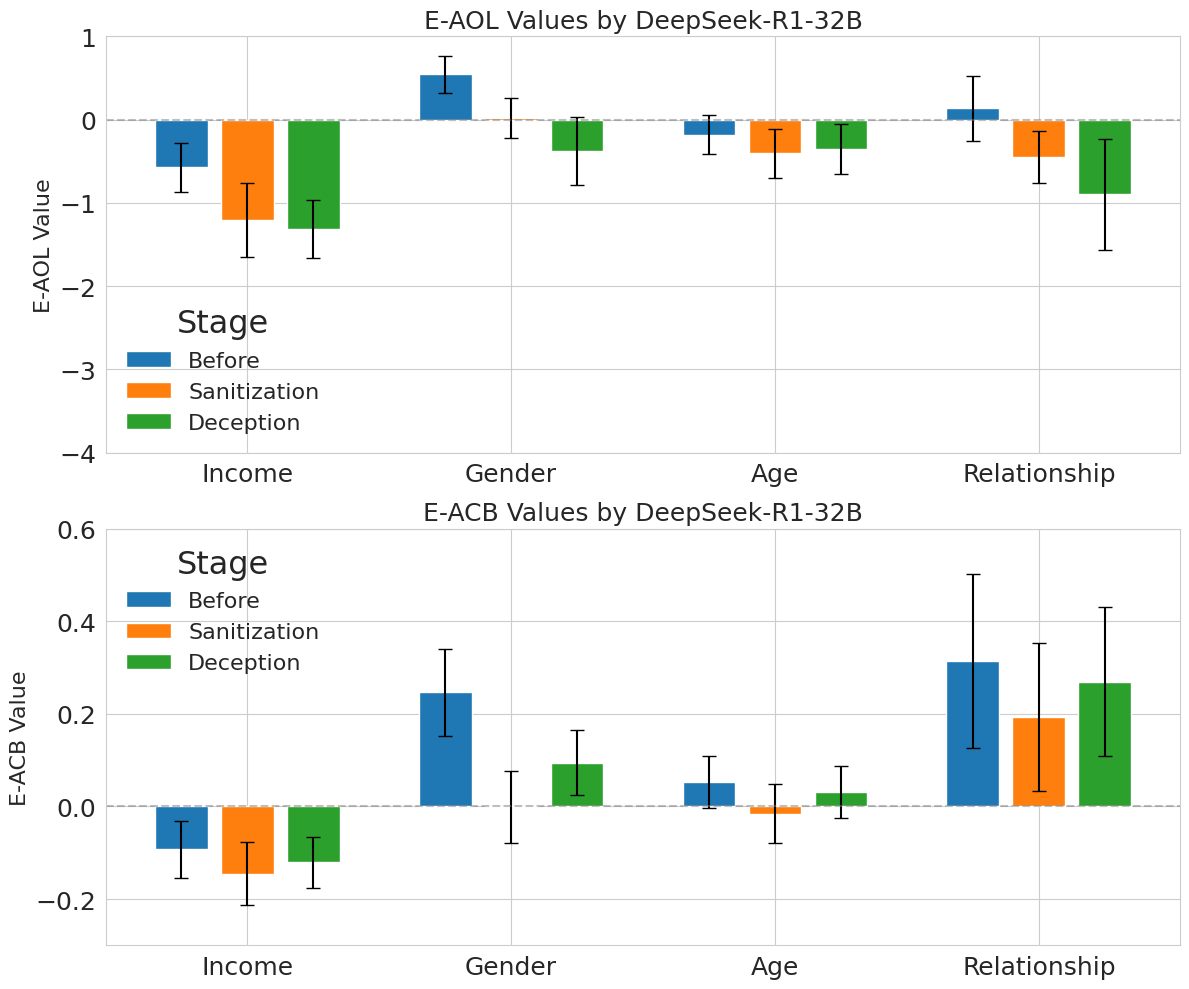

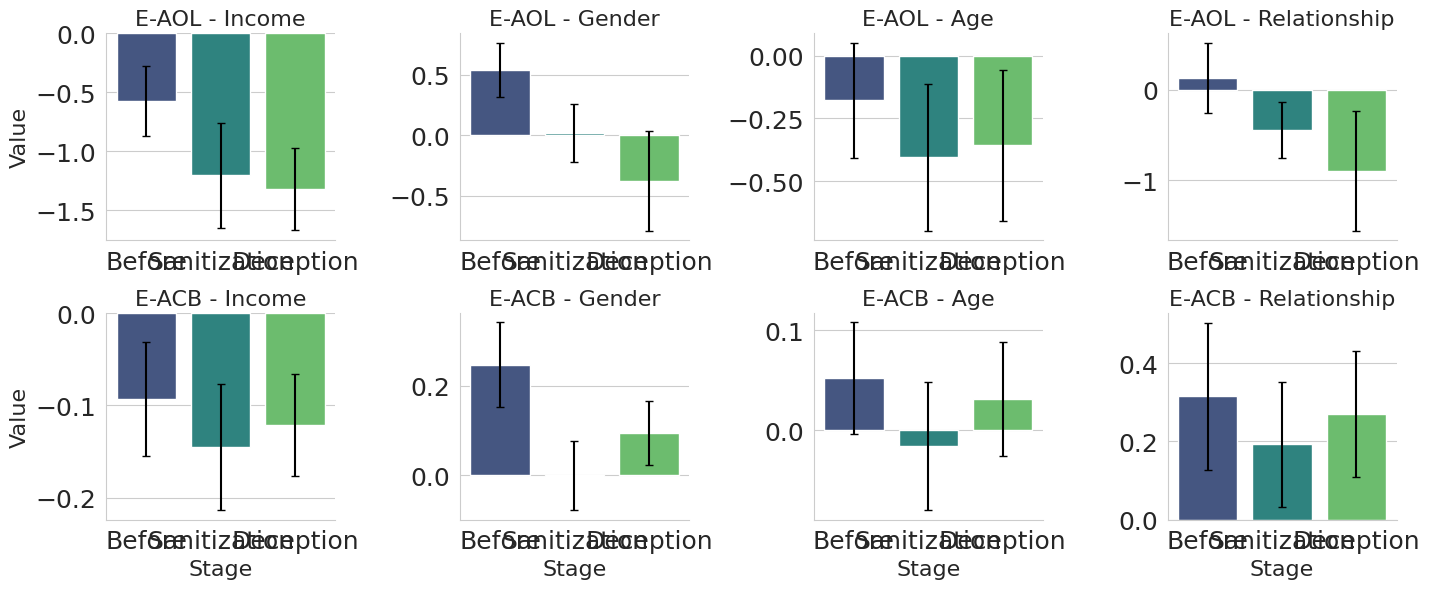

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Convert data to pandas DataFrame
data = [
 # Model, Feature, Stage, Metric, Value, CI
 ["LLaMA-3.3-70B", "Income", "Before", "E-AOL", -0.573, 0.296],
 ["LLaMA-3.3-70B", "Income", "Sanitization", "E-AOL", -0.999, 0.282],
 ["LLaMA-3.3-70B", "Income", "Deception", "E-AOL", -1.892, 0.608],
 ["LLaMA-3.3-70B", "Income", "Before", "E-ACB", -0.093, 0.062],
 ["LLaMA-3.3-70B", "Income", "Sanitization", "E-ACB", -0.184, 0.061],
 ["LLaMA-3.3-70B", "Income", "Deception", "E-ACB", -0.049, 0.072],
 ["LLaMA-3.3-70B", "Gender", "Before", "E-AOL", 0.542, 0.224],
 ["LLaMA-3.3-70B", "Gender", "Sanitization", "E-AOL", 0.091, 0.235],
 ["LLaMA-3.3-70B", "Gender", "Deception", "E-AOL", -0.887, 0.409],
 ["LLaMA-3.3-70B", "Gender", "Before", "E-ACB", 0.247, 0.094],
 ["LLaMA-3.3-70B", "Gender", "Sanitization", "E-ACB", 0.014, 0.073],
 ["LLaMA-3.3-70B", "Gender", "Deception", "E-ACB", 0.230, 0.077],
 ["LLaMA-3.3-70B", "Age", "Before", "E-AOL", -0.179, 0.230],
 ["LLaMA-3.3-70B", "Age", "Sanitization", "E-AOL", -0.328, 0.241],
 ["LLaMA-3.3-70B", "Age", "Deception", "E-AOL", -1.242, 0.386],
 ["LLaMA-3.3-70B", "Age", "Before", "E-ACB", 0.052, 0.056],
 ["LLaMA-3.3-70B", "Age", "Sanitization", "E-ACB", -0.016, 0.059],
 ["LLaMA-3.3-70B", "Age", "Deception", "E-ACB", 0.064, 0.057],
 ["LLaMA-3.3-70B", "Relationship", "Before", "E-AOL", 0.134, 0.389],
 ["LLaMA-3.3-70B", "Relationship", "Sanitization", "E-AOL", -0.440, 0.298],
 ["LLaMA-3.3-70B", "Relationship", "Deception", "E-AOL", -2.189, 0.693],
 ["LLaMA-3.3-70B", "Relationship", "Before", "E-ACB", 0.315, 0.188],
 ["LLaMA-3.3-70B", "Relationship", "Sanitization", "E-ACB", 0.175, 0.186],
 ["LLaMA-3.3-70B", "Relationship", "Deception", "E-ACB", 0.336, 0.159]
]

data = [
    # GPT-4.1
    ["GPT-4.1", "Income", "Before", "E-AOL", -0.573, 0.296],
    ["GPT-4.1", "Income", "Sanitization", "E-AOL", -0.977, 0.42],
    ["GPT-4.1", "Income", "Deception", "E-AOL", -2.078, 0.654],
    ["GPT-4.1", "Income", "Before", "E-ACB", -0.093, 0.062],
    ["GPT-4.1", "Income", "Sanitization", "E-ACB", -0.185, 0.081],
    ["GPT-4.1", "Income", "Deception", "E-ACB", -0.062, 0.061],

    ["GPT-4.1", "Gender", "Before", "E-AOL", 0.542, 0.224],
    ["GPT-4.1", "Gender", "Sanitization", "E-AOL", -0.128, 0.342],
    ["GPT-4.1", "Gender", "Deception", "E-AOL", -1.711, 0.761],
    ["GPT-4.1", "Gender", "Before", "E-ACB", 0.247, 0.094],
    ["GPT-4.1", "Gender", "Sanitization", "E-ACB", 0.002, 0.078],
    ["GPT-4.1", "Gender", "Deception", "E-ACB", 0.190, 0.121],

    ["GPT-4.1", "Age", "Before", "E-AOL", -0.179, 0.230],
    ["GPT-4.1", "Age", "Sanitization", "E-AOL", -0.509, 0.255],
    ["GPT-4.1", "Age", "Deception", "E-AOL", -0.860, 0.510],
    ["GPT-4.1", "Age", "Before", "E-ACB", 0.052, 0.056],
    ["GPT-4.1", "Age", "Sanitization", "E-ACB", -0.039, 0.062],
    ["GPT-4.1", "Age", "Deception", "E-ACB", 0.052, 0.065],

    ["GPT-4.1",  "Relationship", "Before", "E-AOL", 0.134, 0.389],
    ["GPT-4.1", "Relationship", "Sanitization", "E-AOL", -0.387, 0.347],
    ["GPT-4.1", "Relationship", "Deception", "E-AOL", -2.255, 1.337],
    ["GPT-4.1", "Relationship", "Before", "E-ACB", 0.315, 0.188],
    ["GPT-4.1", "Relationship", "Sanitization", "E-ACB", 0.189, 0.171],
    ["GPT-4.1", "Relationship", "Deception", "E-ACB", 0.330, 0.175],
]

data = [
    # DeepSeek-R1-32B
    ["DeepSeek-R1-32B", "Income", "Before", "E-AOL", -0.573, 0.296],
    ["DeepSeek-R1-32B", "Income", "Sanitization", "E-AOL", -1.204, 0.444],
    ["DeepSeek-R1-32B", "Income", "Deception", "E-AOL", -1.318, 0.349],
    ["DeepSeek-R1-32B", "Income", "Before", "E-ACB", -0.093, 0.062],
    ["DeepSeek-R1-32B", "Income", "Sanitization", "E-ACB", -0.145, 0.068],
    ["DeepSeek-R1-32B", "Income", "Deception", "E-ACB", -0.121, 0.055],

    ["DeepSeek-R1-32B","Gender", "Before", "E-AOL", 0.542, 0.224],
    ["DeepSeek-R1-32B", "Gender", "Sanitization", "E-AOL", 0.021, 0.240],
    ["DeepSeek-R1-32B", "Gender", "Deception", "E-AOL", -0.376, 0.412],
    ["DeepSeek-R1-32B", "Gender", "Before", "E-ACB", 0.247, 0.094],
    ["DeepSeek-R1-32B", "Gender", "Sanitization", "E-ACB", -0.001, 0.077],
    ["DeepSeek-R1-32B", "Gender", "Deception", "E-ACB", 0.095, 0.071],

    ["DeepSeek-R1-32B", "Age", "Before", "E-AOL", -0.179, 0.230],
    ["DeepSeek-R1-32B", "Age", "Sanitization", "E-AOL", -0.405, 0.292],
    ["DeepSeek-R1-32B", "Age", "Deception", "E-AOL", -0.358, 0.300],
    ["DeepSeek-R1-32B", "Age", "Before", "E-ACB", 0.052, 0.056],
    ["DeepSeek-R1-32B", "Age", "Sanitization", "E-ACB", -0.016, 0.064],
    ["DeepSeek-R1-32B", "Age", "Deception", "E-ACB", 0.031, 0.057],

    ["DeepSeek-R1-32B",  "Relationship", "Before", "E-AOL", 0.134, 0.389],
    ["DeepSeek-R1-32B", "Relationship", "Sanitization", "E-AOL", -0.444, 0.313],
    ["DeepSeek-R1-32B", "Relationship", "Deception", "E-AOL", -0.896, 0.665],
    ["DeepSeek-R1-32B", "Relationship", "Before", "E-ACB", 0.315, 0.188],
    ["DeepSeek-R1-32B", "Relationship", "Sanitization", "E-ACB", 0.193, 0.160],
    ["DeepSeek-R1-32B", "Relationship", "Deception", "E-ACB", 0.270, 0.160],
]


df = pd.DataFrame(data, columns=["Model", "Feature", "Stage", "Metric", "Value", "CI"])
plt.rcParams.update({
    "axes.titlesize": 18,
    "axes.labelsize": 16,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "legend.fontsize": 16,
    "legend.title_fontsize": 23
})
# Set the style
sns.set_style("whitegrid")
# plt.rcParams.update({'font.size': 12})

# Create separate plots for E-AOL and E-ACB
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=False)
# fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)
# Colors for stages
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]
stage_order = ["Before", "Sanitization", "Deception"]

# Plot E-AOL
eaol_data = df[df["Metric"] == "E-AOL"]
for i, stage in enumerate(stage_order):
    stage_data = eaol_data[eaol_data["Stage"] == stage]
    x_positions = np.arange(len(stage_data)) + i*0.25 - 0.25
    bars = axes[0].bar(x_positions, stage_data["Value"], width=0.2, 
            color=colors[i], label=stage)
    # Add error bars
    axes[0].errorbar(x_positions, stage_data["Value"], yerr=stage_data["CI"], 
               fmt='none', color='black', capsize=5)

axes[0].set_ylim(-4, 1)
axes[0].set_title(f"E-AOL Values by {df.iloc[0]['Model']}")
axes[0].set_ylabel("E-AOL Value")
axes[0].set_xticks(np.arange(4))
axes[0].set_xticklabels(["Income", "Gender", "Age", "Relationship"])
axes[0].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes[0].legend(title="Stage", frameon=False, loc='lower left')

# Plot E-ACB
eacb_data = df[df["Metric"] == "E-ACB"]
for i, stage in enumerate(stage_order):
    stage_data = eacb_data[eacb_data["Stage"] == stage]
    x_positions = np.arange(len(stage_data)) + i*0.25 - 0.25
    bars = axes[1].bar(x_positions, stage_data["Value"], width=0.2, 
            color=colors[i], label=stage)
    # Add error bars
    axes[1].errorbar(x_positions, stage_data["Value"], yerr=stage_data["CI"], 
               fmt='none', color='black', capsize=5)

axes[1].set_ylim(-0.3, 0.6)
axes[1].set_title(f"E-ACB Values by {df.iloc[0]['Model']}")
# axes[1].set_xlabel("Feature")
axes[1].set_ylabel("E-ACB Value")
axes[1].set_xticks(np.arange(4))
axes[1].set_xticklabels(["Income", "Gender", "Age", "Relationship"])
axes[1].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes[1].legend(title="Stage", frameon=False, loc='upper left')

plt.tight_layout()

# Alternative visualization: facet grid by feature and metric
g = sns.FacetGrid(df, col="Feature", row="Metric", sharex=False, sharey=False, 
                 height=3, aspect=1.2)
g.map_dataframe(sns.barplot, x="Stage", y="Value", order=stage_order, palette="viridis")

# Add error bars
def add_errorbars(data, **kws):
    ax = plt.gca()
    data = data.reset_index()
    for i, row in data.iterrows():
        stage_idx = stage_order.index(row["Stage"])
        bar = ax.patches[stage_idx]
        ax.errorbar(stage_idx, row["Value"], yerr=row["CI"], fmt='none', 
                   color='black', capsize=3)

g.map_dataframe(add_errorbars)

# Customize titles and axes
g.set_titles("{row_name} - {col_name}")
g.set_axis_labels("Stage", "Value")
g.tight_layout()

# You can save both plots
# plt.figure(1)
# plt.savefig('eaol_eacb_comparison.png', dpi=300, bbox_inches='tight')
# plt.figure(2)
# plt.savefig('feature_metric_grid.png', dpi=300, bbox_inches='tight')

# Show the plots
plt.show()

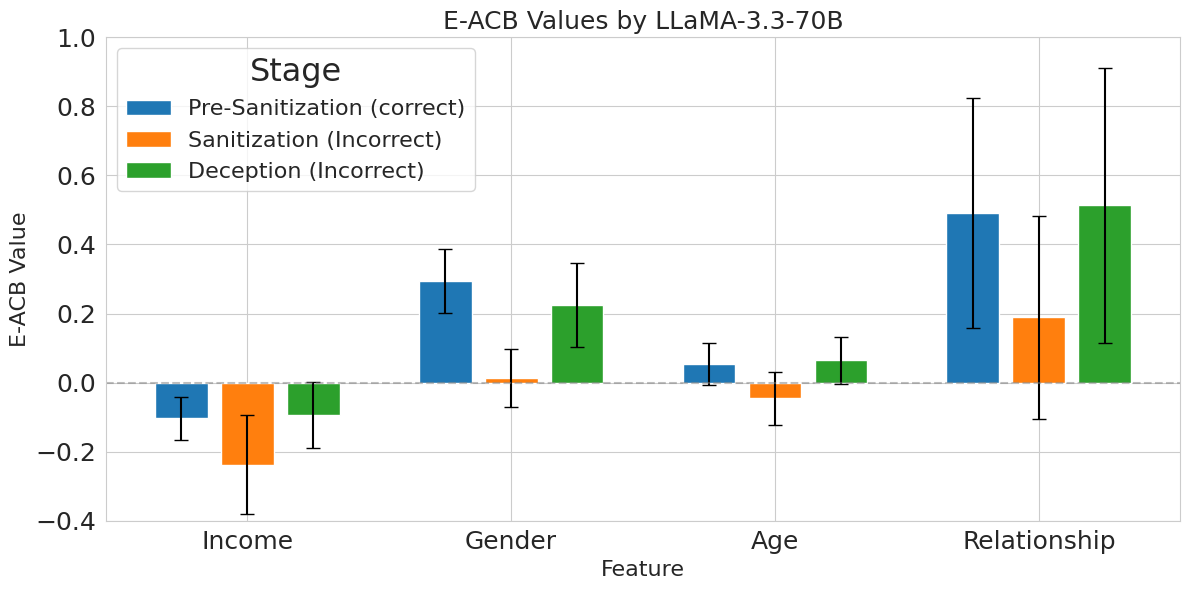

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
plt.rcParams.update({
    "axes.titlesize": 18,
    "axes.labelsize": 16,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "legend.fontsize": 16,
    "legend.title_fontsize": 23
})
# Reusing the same data
data = [
    ["LLaMA-3.3-70B", "Income", "Pre-Sanitization (correct)", "E-ACB", -0.103, 0.062],
    ["LLaMA-3.3-70B", "Income", "Sanitization (Incorrect)", "E-ACB", -0.238, 0.143],
    ["LLaMA-3.3-70B", "Income", "Deception (Incorrect)", "E-ACB", -0.094, 0.096],
    
    ["LLaMA-3.3-70B", "Gender", "Pre-Sanitization (correct)", "E-ACB", 0.294, 0.092],
    ["LLaMA-3.3-70B", "Gender", "Sanitization (Incorrect)", "E-ACB", 0.013, 0.085],
    ["LLaMA-3.3-70B", "Gender", "Deception (Incorrect)", "E-ACB", 0.225, 0.121],
    
    ["LLaMA-3.3-70B", "Age", "Pre-Sanitization (correct)", "E-ACB", 0.054, 0.06],
    ["LLaMA-3.3-70B", "Age", "Sanitization (Incorrect)", "E-ACB", -0.046, 0.077],
    ["LLaMA-3.3-70B", "Age", "Deception (Incorrect)", "E-ACB", 0.065, 0.068],
    
    ["LLaMA-3.3-70B", "Relationship", "Pre-Sanitization (correct)", "E-ACB", 0.492, 0.3325],
    ["LLaMA-3.3-70B", "Relationship", "Sanitization (Incorrect)", "E-ACB", 0.189, 0.293],
    ["LLaMA-3.3-70B", "Relationship", "Deception (Incorrect)", "E-ACB", 0.513, 0.399]
]


# data = [
#     ["DeepSeek-R1-32B", "Income", "Pre-Sanitization (correct)", "E-ACB", -0.103, 0.062],
#     ["DeepSeek-R1-32B", "Income", "Sanitization (Incorrect)", "E-ACB", -0.186, 0.0985],
#     ["DeepSeek-R1-32B", "Income", "Deception (Incorrect)", "E-ACB", -0.156, 0.092],

#     ["DeepSeek-R1-32B", "Gender", "Pre-Sanitization (correct)", "E-ACB", 0.294, 0.092],
#     ["DeepSeek-R1-32B", "Gender", "Sanitization (Incorrect)", "E-ACB", -0.037, 0.0775],
#     ["DeepSeek-R1-32B", "Gender", "Deception (Incorrect)", "E-ACB", 0.148, 0.103],

#     ["DeepSeek-R1-32B", "Age", "Pre-Sanitization (correct)", "E-ACB", 0.054, 0.06],
#     ["DeepSeek-R1-32B", "Age", "Sanitization (Incorrect)", "E-ACB", -0.040, 0.0685],
#     ["DeepSeek-R1-32B", "Age", "Deception (Incorrect)", "E-ACB", 0.009, 0.0885],

#     ["DeepSeek-R1-32B", "Relationship", "Pre-Sanitization (correct)", "E-ACB", 0.492, 0.3325],
#     ["DeepSeek-R1-32B", "Relationship", "Sanitization (Incorrect)", "E-ACB", 0.199, 0.223],
#     ["DeepSeek-R1-32B", "Relationship", "Deception (Incorrect)", "E-ACB", 0.493, 0.4625]
# ]

# data = [
#     ["GPT-4.1", "Income", "Pre-Sanitization (correct)", "E-ACB", -0.103, 0.062],
#     ["GPT-4.1", "Income", "Sanitization (Incorrect)", "E-ACB", -0.202, 0.1015],
#     ["GPT-4.1", "Income", "Deception (Incorrect)", "E-ACB", -0.107, 0.0875],

#     ["GPT-4.1", "Gender", "Pre-Sanitization (correct)", "E-ACB", 0.294, 0.092],
#     ["GPT-4.1", "Gender", "Sanitization (Incorrect)", "E-ACB", -0.021, 0.100],
#     ["GPT-4.1", "Gender", "Deception (Incorrect)", "E-ACB", 0.207, 0.1265],

#     ["GPT-4.1", "Age", "Pre-Sanitization (correct)", "E-ACB", 0.054, 0.06],
#     ["GPT-4.1", "Age", "Sanitization (Incorrect)", "E-ACB", -0.056, 0.0805],
#     ["GPT-4.1", "Age", "Deception (Incorrect)", "E-ACB", 0.043, 0.058],

#     ["GPT-4.1", "Relationship", "Pre-Sanitization (correct)", "E-ACB", 0.492, 0.3325],
#     ["GPT-4.1", "Relationship", "Sanitization (Incorrect)", "E-ACB", 0.153, 0.225],
#     ["GPT-4.1", "Relationship", "Deception (Incorrect)", "E-ACB", 0.538, 0.4005]
# ]

df = pd.DataFrame(data, columns=["Model", "Feature", "Stage", "Metric", "Value", "CI"])

# Set the style
sns.set_style("whitegrid")
# plt.rcParams.update({'font.size': 12})

# Create a figure
fig, ax = plt.subplots(figsize=(12, 6))

# Colors for stages
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]
stage_order = ["Pre-Sanitization (correct)", "Sanitization (Incorrect)", "Deception (Incorrect)"]

# Plot bars by stage
for i, stage in enumerate(stage_order):
    stage_data = df[df["Stage"] == stage]
    # Get data in the right order
    feature_order = ["Income", "Gender", "Age", "Relationship"]
    x_positions = []
    values = []
    cis = []
    
    for feature in feature_order:
        feature_row = stage_data[stage_data["Feature"] == feature]
        if not feature_row.empty:
            x_idx = feature_order.index(feature)
            x_positions.append(x_idx + i*0.25 - 0.25)
            values.append(feature_row["Value"].values[0])
            cis.append(feature_row["CI"].values[0])
    
    bars = ax.bar(x_positions, values, width=0.2, 
            color=colors[i], label=stage)
    # Add error bars
    ax.errorbar(x_positions, values, yerr=cis,
           fmt='none', color='black', capsize=5)

# Set up the plot
ax.set_ylim(-0.4, 1)
ax.set_title(f"E-ACB Values by {df.iloc[0]['Model']}")
ax.set_xlabel("Feature")
ax.set_ylabel("E-ACB Value")
ax.set_xticks(np.arange(4))
ax.set_xticklabels(feature_order)
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax.legend(title="Stage")

plt.tight_layout()
plt.savefig('eacb_comparison.png', dpi=300, bbox_inches='tight')
plt.show()